In [1]:
# Benchmark contra baseline

# test all vs all (que tan parecidos son los sujetos)
# cambiar Nt

# Finetuning

# Prueba en tiempo real

In [2]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import scipy.stats as stats
from datetime import date

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
from main_classes.DataRetriever import DataGetter, DataSearcher, load_npz
from main_classes.ResultDisplayer import (
    plot_metric_results, 
    plot_statistical_groups,
    plot_pred,
    plot_prediction,
    plot_mcdropout,
    plot_config_prediction
)
from utils.process_helpers import split_trials_from_scanpath
from main_classes.MetricsCalculator import calculate_multimatch, detect_sac_fix_from_scanpath, calculate_scanmatch

from utils.utils import merge_dicts

from utils.ScanMatchCalculator import ScanMatch_Struct, ScanMatch_FixationToSequence, ScanMatch 


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
#model_name = "PosScan" #"MCD"
#model_name = "FovSOS-FS" 
model_name = "FovSOS-FS_DirectPred"


In [7]:
RESULTS_FOLDER = f"../results/{model_name}/" #"../results/MCDropout/"
SAVE_FOLDER = f"../results_plots/{model_name}/"

dates_results = {
    "MCD": "28072021",
    "PosScan": "28072021",
    "FovSOS-FS": "04012022", #"FovSOS-FS": "17112021",
    "FovSOS-FS_DirectPred": "25112021" #"FovSOS-FS_DirectPred": "17112021",
}

In [8]:
horizons = {
    1: {
        "MCD": [1, 1], #[N, Nt]
        "PosScan": [1, 1], #[N, Nt]
        "FovSOS-FS": [1, 1],
        "FovSOS-FS_DirectPred": [1, 1],
    },
    5: {
        "MCD": [5, 1],
        "PosScan": [5, 1],
        "FovSOS-FS": [5, 1],
        "FovSOS-FS_DirectPred": [1, 5],
    },
    11: {
        "MCD": [11, 1],
        "PosScan": [11, 1],
        "FovSOS-FS": [11, 1],
        "FovSOS-FS_DirectPred": [1, 11],
    },
    20: {
        "MCD": [20, 1],
        "PosScan": [20, 1],
        "FovSOS-FS": [20, 1],
        "FovSOS-FS_DirectPred": [1, 20],
    }
    
}

In [9]:
load_results = True
save_results = False

if load_results:
    date_results = dates_results[model_name]
else:
    date_results = date.today().strftime("%d%m%Y")
    
#SAVE FIGURES
is_save = False #True

# Calculate or Load results

In [10]:
#select_metrics = ["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "rec", "multimatch"]
select_metrics = ["MSE", "peak_x", "peak_y", "scanmatch", "multimatch"]

In [11]:
# Load Results
#with open('./assets/results_all_14072021.json') as data_file: 
if load_results:
    with open(f'../results/assets/{model_name}/results_all_{date_results}.json') as data_file: 
        all_results = json.load(data_file)
else:
    data_getter = DataGetter(RESULTS_FOLDER)
    all_results = data_getter.calculate_metrics_results(only_all_vs_all=False, select_metrics=select_metrics)

# Save Results
if save_results:
    with open(f'../results/assets/{model_name}/results_all_{date_results}.json', 'w') as f: #results_dict_test
        json.dump(all_results, f)

In [12]:
# Load Results
#with open('./assets/results_all_vs_all_14072021.json') as data_file:
if load_results:
    with open(f'../results/assets/{model_name}/results_all_vs_all_{date_results}.json') as data_file:
        results_all_vs_all = json.load(data_file)
else:    
    data_getter = DataGetter(RESULTS_FOLDER)
    results_all_vs_all = data_getter.calculate_metrics_results(only_all_vs_all=True, select_metrics=select_metrics)

# Save Results
if save_results:
    with open(f'../results/assets/{model_name}/results_all_vs_all_{date_results}.json', 'w') as f: 
        json.dump(results_all_vs_all, f)

# Retrieve results by query

In [13]:
IMG_TYPES = ['natural', 'inverted', 'white_noise', 'pink_noise', 'white', 'black', 'grey']
MULTIMATCH_DIMS = ["shape", "direction", "length", "position", "duration"]

In [14]:
searcher = DataSearcher()

In [15]:
# Example of use:
df = searcher.get_results_by_query(all_results, 
                     metric="peak_x", 
                     subject=None, 
                     tIMG=None, 
                     N=20, 
                     Nt=None, 
                     SEQ=None, 
                     INuts=None, 
                     LR=None, 
                     EPOCHS=None, 
                     PAT=None, 
                     predIMG=None, 
                     #is_all_vs_all=True
                   )[0].apply(pd.Series)
df

Series([], Name: 0, dtype: float64)

In [16]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def get_results_with_image_types_indexes(df):
    """
    Transform results from searching by adding tIMG and predIMG columns
    """
    idx = df.index.str.extract(r"tIMG_(.+?)-.+predIMG_?(.*)")
    df_concat = pd.concat([idx, df.reset_index(drop=True)], axis=1)
    df_concat.columns = ["tIMG", "predIMG"] + list(map(lambda x: f"metric_{x}", range(len(df.columns))))
    #df_concat.columns = ["tIMG", "predIMG"] + list(range(len(df.columns)))
    return df_concat

def group_metrics(df, group_img_type, filter_same_groups=False):
    """
    Transform metrics, grouping by img type.
    group_img_type: str -> tIMG or predIMG
    """
    if (group_img_type != "tIMG") and (group_img_type != "predIMG"):
        print(f"Please choose group_img_type={group_img_type} in ['tIMG', 'predIMG']")
        return
    # Transform results from searcher
    df_groups = get_results_with_image_types_indexes(df)
    if filter_same_groups:
        df_groups = df_groups[df_groups["tIMG"] != df_groups["predIMG"]]
    # Store metrics in dictionary
    metrics_grouped_by_img_type = {}
    for i_comp in df_groups.columns[2:]:
        metric_comp_arr = []
        for img_type in IMG_TYPES:
            # Select by group of img and by i-component metric
            df_metric_comp = df_groups[df_groups[group_img_type] == img_type][i_comp].to_frame().reset_index(drop=True).T
            df_metric_comp.index = [img_type]
            # Store results by img_type
            metric_comp_arr.append(df_metric_comp)
        # Save results in dictionary by i-component metric, concat all image types in one dataframe
        metrics_grouped_by_img_type[i_comp] = pd.concat(metric_comp_arr).T
    metrics_grouped_by_img_type = pd.concat(metrics_grouped_by_img_type)
    return metrics_grouped_by_img_type

def calculate_KL(metrics_grouped_by_img_type):
    from scipy.special import kl_div, rel_entr
    kl_divs = np.empty((len(metrics_grouped_by_img_type.columns), len(metrics_grouped_by_img_type.columns)))
    for i, p_img_type in enumerate(metrics_grouped_by_img_type.columns):
        P = metrics_grouped_by_img_type[p_img_type]
        for j, q_img_type in enumerate(metrics_grouped_by_img_type.columns):
            Q = metrics_grouped_by_img_type[q_img_type]
            pq_div = rel_entr(P, Q).sum() 
            qp_div = rel_entr(Q, P).sum()
            kl_divs[i, j] = (pq_div + qp_div)/2
    return pd.DataFrame(kl_divs, columns=metrics_grouped_by_img_type.columns, index=metrics_grouped_by_img_type.columns)

def calculate_MI(metrics_grouped_by_img_type):
    from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
    MI = np.empty((len(metrics_grouped_by_img_type.columns), len(metrics_grouped_by_img_type.columns)))
    for i, p_img_type in enumerate(metrics_grouped_by_img_type.columns):
        P = metrics_grouped_by_img_type[p_img_type]
        for j, q_img_type in enumerate(metrics_grouped_by_img_type.columns):
            Q = metrics_grouped_by_img_type[q_img_type]
            pq_mi = adjusted_mutual_info_score(P, Q)
            qp_mi = adjusted_mutual_info_score(Q, P)
            #MI[i, j] = (pq_mi + qp_mi)/2
            MI[i, j] = pq_mi
            MI[j, i] = qp_mi
    return pd.DataFrame(MI, columns=metrics_grouped_by_img_type.columns, index=metrics_grouped_by_img_type.columns)

In [17]:
from scipy.optimize import curve_fit

def powerlaw(x, alpha, beta):
    return alpha * np.power(x, beta)
try:
    df = searcher.get_results_by_query(all_results, 
                             metric="multimatch", 
                             subject=None, 
                             tIMG=None, 
                             N=20,
                             Nt=1,
                             predIMG=None
                            )[0].apply(pd.Series)
    metrics_grouped_by_img_type = group_metrics(df, group_img_type="tIMG")
    #metrics_grouped_by_img_type = group_metrics(df, group_img_type="predIMG")

    corrs = metrics_grouped_by_img_type.loc["metric_0"].corr()

    for p, img_type_p in enumerate(IMG_TYPES):
        for img_type_q in IMG_TYPES:
            #popt, pcov = curve_fit(powerlaw, metrics_grouped_by_img_type[img_type_p], metrics_grouped_by_img_type[img_type_q])
            plt.plot(metrics_grouped_by_img_type[img_type_p], metrics_grouped_by_img_type[img_type_q], "*")
            #plt.plot(metrics_grouped_by_img_type[img_type_p], powerlaw(metrics_grouped_by_img_type[img_type_p], *popt), "+", label=f"alpha={popt[0]:.2f}, beta={popt[1]:.2f}")
            plt.title(f"{img_type_p}, {img_type_q}, corr={corrs[img_type_p][img_type_q]:.2f}")
            #plt.legend()
            plt.show()
except:
    pass

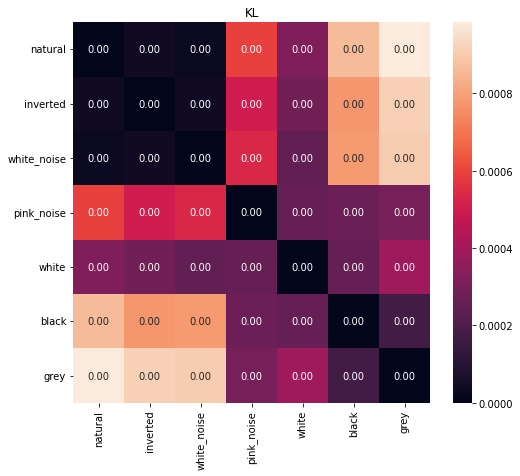

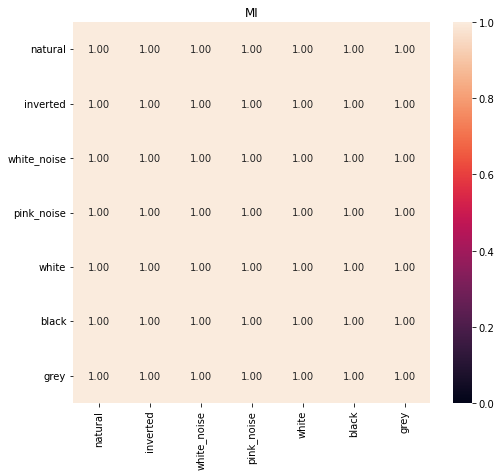

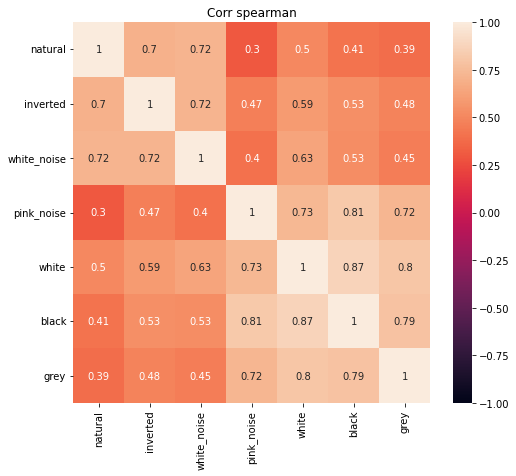

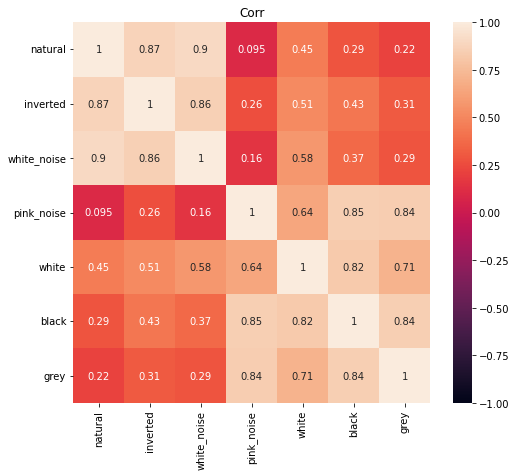

In [18]:
try:
    # Example of use:
    df = searcher.get_results_by_query(all_results, 
                         metric="multimatch", 
                         subject=None, 
                         tIMG=None, 
                         N=1, 
                         Nt=1, 
                         SEQ=None, 
                         INuts=None, 
                         LR=None, 
                         EPOCHS=None, 
                         PAT=None, 
                         predIMG=None, 
                         #is_all_vs_all=True
                       )[0].apply(pd.Series)

    metrics_grouped_by_img_type = group_metrics(df, group_img_type="tIMG")
    #for img_type in metrics_grouped_by_img_type.columns:
    #    metrics_grouped_by_img_type[img_type] += 1e-10#np.random.randn(metrics_grouped_by_img_type[img_type].shape[0]) * 1e-1000


    # Jensen-Shannon Divergence
    kl_divs = calculate_KL(metrics_grouped_by_img_type.loc["metric_0"])
    fig, ax = plt.subplots(1,1, figsize=(8,7))
    sns.heatmap(kl_divs, ax=ax,
                xticklabels=metrics_grouped_by_img_type.columns,
                yticklabels=metrics_grouped_by_img_type.columns, annot=True, fmt=".2f"
                )
    plt.title("KL")
    plt.show()


    mi = calculate_MI(metrics_grouped_by_img_type.loc["metric_0"])
    fig, ax = plt.subplots(1,1, figsize=(8,7))
    sns.heatmap(mi, ax=ax,
                xticklabels=metrics_grouped_by_img_type.columns,
                yticklabels=metrics_grouped_by_img_type.columns, annot=True, fmt=".2f",
                vmin=0
                )
    plt.title("MI")
    plt.show()

    # Correlations
    cmap = sns.cm.rocket

    corrs = metrics_grouped_by_img_type.loc["metric_0"].corr(method="spearman")
    fig, ax = plt.subplots(1,1, figsize=(8,7))
    sns.heatmap(corrs, ax=ax,
                xticklabels=corrs.columns,
                yticklabels=corrs.columns, annot=True, cmap=cmap,
                vmin=-1, vmax=1)
    plt.title("Corr spearman")
    plt.show()


    corrs = metrics_grouped_by_img_type.loc["metric_0"].corr()
    fig, ax = plt.subplots(1,1, figsize=(8,7))
    sns.heatmap(corrs, ax=ax,
                xticklabels=corrs.columns,
                yticklabels=corrs.columns, annot=True, cmap=cmap,
                vmin=-1, vmax=1)
    plt.title("Corr")
    plt.show()
except:
    pass

# General Results

In [19]:
def _parse_lim(x_lim, HORIZONS=[1, 5, 11, 20]):
    for metric_name, values in x_lim.items():
        if not isinstance(values, dict):
            x_lim[metric_name] = {
                horizon: values for horizon in HORIZONS
            }
    return x_lim
    
def plot_metrics(all_results, metrics, kind, grouped_by, IMG_TYPES, horizons, model_name, is_save, **kwargs):
    assert grouped_by in ["groupedTrain", "groupedPredicted"]
    # Kwargs
    sharex = kwargs.get("sharex", False)
    sharey = kwargs.get("sharey", False)
    x_lim_left = kwargs.get("x_lim_left", {})
    x_lim_right = kwargs.get("x_lim_right", {})
    y_lim_top = kwargs.get("y_lim_top", {})
    if x_lim_left.get("all") is not None:
        x_lim_left = {
            metric: x_lim_left["all"] for metric in metrics
        }
    if x_lim_right.get("all") is not None:
        x_lim_right = {
            metric: x_lim_right["all"] for metric in metrics
        }
    if y_lim_top.get("all") is not None:
        y_lim_top = {
            metric: y_lim_top["all"] for metric in metrics
        }
    x_lim_left = _parse_lim(x_lim_left)
    x_lim_right = _parse_lim(x_lim_right)
    y_lim_top = _parse_lim(y_lim_top)
    # Plotting
    for metric in metrics:
        fig, ax = plt.subplots(1, 4, figsize=(14, 3), sharex=sharex, sharey=sharey)
        for i, h in enumerate([1, 5, 11, 20]):
            N, Nt = horizons[h][model_name]
            for j, img_type in enumerate(IMG_TYPES):
                if grouped_by == "groupedTrain":
                    df = searcher.get_results_by_query(all_results, 
                                     metric=metric, 
                                     subject=None, 
                                     tIMG=img_type, 
                                     N=N,
                                     Nt=Nt,
                                     predIMG=None
                    )
                if grouped_by == "groupedPredicted":
                     df = searcher.get_results_by_query(all_results, 
                                     metric=metric, 
                                     subject=None, 
                                     tIMG=None, 
                                     N=N,
                                     Nt=Nt,
                                     predIMG=img_type
                    )
                if (not df.empty) and (not pd.isna(df[0]).all()):
                    if kind == "bar":
                        ax[i].barh(img_type, df[0].mean(), xerr=df[0].std(), color=f"C{j}")
                    if kind == "dist":
                        sns.kdeplot(df[0], ax=ax[i], label=img_type)
                    if kind == "cumdist":
                        sns.kdeplot(df[0], ax=ax[i], label=img_type, cumulative=True)
                else:
                    if kind == "bar":
                        ax[i].barh(img_type, 0.0, xerr=0.0, color=f"C{j}")
                    if kind == "dist":
                        ax[i].axvline(x=0.0, label=img_type, color=f"C{j}")
                    if kind == "cumdist":
                        ax[i].axhline(y=0.0, label=img_type, color=f"C{j}")    
            ax[i].set_title(f"h={h}", fontsize=16)
            ax[i].set_xlabel(metric, fontsize=14)
            ax[i].tick_params(axis='y', labelsize=14)
            ax[i].set_xlim(left=x_lim_left.get(metric, {}).get(h, None), right=x_lim_right.get(metric, {}).get(h, None))
            ax[i].set_ylim(top=y_lim_top.get(metric, {}).get(h, None))
            ax[i].grid()
        if kind != "bar":
            ax[i].legend(prop={"size":8})
        add_to_suptitle = {
            "bar": " ",
            "dist": " distribution ",
            "cumdist": " cumulative distribution "
        }
        plt.suptitle(
            f"{model_name} - {metric}{add_to_suptitle[kind]}grouping subjects by {grouped_by.split('grouped')[-1].lower()} image", 
            y=1.0,
            fontsize=16
        )
        fig.tight_layout()
        if is_save:
            savepath = os.path.join(SAVE_FOLDER, f"general/grouped/")
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            fig.savefig(f"{os.path.join(savepath, f'{metric}_{kind}_{grouped_by}')}.png")
        plt.show()

In [60]:
def plot_corrs(all_results, metrics, grouped_by, IMG_TYPES, horizons, model_name, is_save, **kwargs):
    assert grouped_by in ["groupedTrain", "groupedPredicted"]
    # Kwargs
    sharex = kwargs.get("sharex", False)
    sharey = kwargs.get("sharey", False)
    # Plotting
    for metric in metrics:
        fig, ax = plt.subplots(1, 4, figsize=(19, 5), sharex=sharex, sharey=sharey)
        for i, h in enumerate([1, 5, 11, 20]):
            N, Nt = horizons[h][model_name]
            arr_type = []
            df = searcher.get_results_by_query(all_results, 
                                 metric=metric, 
                                 subject=None, 
                                 tIMG=None, 
                                 N=N,
                                 Nt=Nt,
                                 predIMG=None
            )
            if grouped_by == "groupedTrain":
                metrics_grouped_by_img_type = group_metrics(df, group_img_type="tIMG")
            if grouped_by == "groupedPredicted":
                 metrics_grouped_by_img_type = group_metrics(df, group_img_type="predIMG")
            corrs = metrics_grouped_by_img_type.loc["metric_0"].corr()
            cbar = False if i != 3 else True
            sns.heatmap(corrs, ax=ax[i], 
                xticklabels=corrs.columns,
                yticklabels=corrs.columns, annot=True, fmt=".2f", 
                vmin=-1, vmax=1, cbar=cbar, square=True
            )
            ax[i].set_title(f"h={h}", fontsize=18)
            ax[i].tick_params(axis='both', which='major', labelsize=16)
            
        plt.suptitle(f"{model_name} Model - {metric} correlation grouping subjects by {grouped_by.split('grouped')[-1].lower()} image", y=1.0, fontsize=18)
        fig.tight_layout()
        if is_save:
            savepath = os.path.join(SAVE_FOLDER, f"general/grouped/")
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            fig.savefig(f"{os.path.join(savepath, f'{metric}_corr_{grouped_by}')}.png")
        plt.show()

In [21]:
def plot_metrics_mm(all_results, MULTIMATCH_DIMS, kind, grouped_by, IMG_TYPES, horizons, model_name, is_save, **kwargs):
    assert grouped_by in ["groupedTrain", "groupedPredicted"]
    metric = "multimatch"
    # Kwargs
    sharex = kwargs.get("sharex", False)
    sharey = kwargs.get("sharey", False)
    x_lim_left = kwargs.get("x_lim_left", {})
    x_lim_right = kwargs.get("x_lim_right", {})
    y_lim_top = kwargs.get("y_lim_top", {})
    if x_lim_left.get("all") is not None:
        x_lim_left = {
            metric: x_lim_left["all"] for metric in MULTIMATCH_DIMS
        }
    if x_lim_right.get("all") is not None:
        x_lim_right = {
            metric: x_lim_right["all"] for metric in MULTIMATCH_DIMS
        }
    if y_lim_top.get("all") is not None:
        y_lim_top = {
            metric: y_lim_top["all"] for metric in metrics
        }
    x_lim_left = _parse_lim(x_lim_left)
    x_lim_right = _parse_lim(x_lim_right)
    y_lim_top = _parse_lim(y_lim_top)
    # Plotting
    for m_dim, multimatch_dim in enumerate(MULTIMATCH_DIMS):
        fig, ax = plt.subplots(1, 4, figsize=(14, 3), sharex=sharex, sharey=sharey)
        for i, h in enumerate([1, 5, 11, 20]):
            N, Nt = horizons[h][model_name]
            for j, img_type in enumerate(IMG_TYPES):
                if grouped_by == "groupedTrain":
                    df = searcher.get_results_by_query(all_results, 
                                     metric=metric, 
                                     subject=None, 
                                     tIMG=img_type, 
                                     N=N,
                                     Nt=Nt,
                                     predIMG=None
                    )[0].apply(pd.Series)
                if grouped_by == "groupedPredicted":
                     df = searcher.get_results_by_query(all_results, 
                                     metric=metric, 
                                     subject=None, 
                                     tIMG=None, 
                                     N=N,
                                     Nt=Nt,
                                     predIMG=img_type
                    )[0].apply(pd.Series)
                if (not df.empty) and (not pd.isna(df[0]).all()):
                    if kind == "bar":
                        ax[i].barh(img_type, df[m_dim].mean(), xerr=df[m_dim].std(), color=f"C{j}")
                    if kind == "dist":
                        sns.kdeplot(df[m_dim], ax=ax[i], label=img_type)
                    if kind == "cumdist":
                        sns.kdeplot(df[m_dim], ax=ax[i], label=img_type, cumulative=True)
                else:
                    if kind == "bar":
                        ax[i].barh(img_type, 0.0, xerr=0.0, color=f"C{j}")
                    if kind == "dist":
                        ax[i].axvline(x=0.0, label=img_type, color=f"C{j}")
                    if kind == "cumdist":
                        ax[i].axhline(y=0.0, label=img_type, color=f"C{j}")    
            ax[i].set_title(f"h={h}")
            ax[i].set_xlabel(multimatch_dim)
            ax[i].set_xlim(left=x_lim_left.get(multimatch_dim, {}).get(h, None), right=x_lim_right.get(multimatch_dim, {}).get(h, None))
            ax[i].set_ylim(top=y_lim_top.get(multimatch_dim, {}).get(h, None))
            ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax[i].grid()
        if kind != "bar":
            ax[i].legend(prop={"size":8}) 
        add_to_suptitle = {
            "bar": " ",
            "dist": " distribution ",
            "cumdist": " cumulative distribution "
        }
        fig.suptitle(f"{model_name} Model - {metric} {multimatch_dim}{add_to_suptitle[kind]}grouping subjects by {grouped_by.split('grouped')[-1].lower()} image", y=1.0)
        fig.tight_layout()
        if is_save:
            savepath = os.path.join(SAVE_FOLDER, f"general/grouped/")
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            fig.savefig(f"{os.path.join(savepath, f'{metric}_{multimatch_dim}_{kind}_{grouped_by}')}.png")
        plt.show()

In [22]:
def plot_corrs_mm(all_results, MULTIMATCH_DIMS, grouped_by, IMG_TYPES, horizons, model_name, is_save, **kwargs):
    assert grouped_by in ["groupedTrain", "groupedPredicted"]
    # Kwargs
    sharex = kwargs.get("sharex", False)
    sharey = kwargs.get("sharey", False)
    metric = "multimatch"
    # Plotting
    for m_dim, multimatch_dim in enumerate(MULTIMATCH_DIMS):
        fig, ax = plt.subplots(1, 4, figsize=(19, 5), sharex=sharex, sharey=sharey)
        for i, h in enumerate([1, 5, 11, 20]):
            N, Nt = horizons[h][model_name]
            df = searcher.get_results_by_query(all_results, 
                                 metric=metric, 
                                 subject=None, 
                                 tIMG=None, 
                                 N=N,
                                 Nt=Nt,
                                 predIMG=None
            )[0].apply(pd.Series)
            if grouped_by == "groupedTrain":
                metrics_grouped_by_img_type = group_metrics(df, group_img_type="tIMG")
            if grouped_by == "groupedPredicted":
                 metrics_grouped_by_img_type = group_metrics(df, group_img_type="predIMG")
            corrs = metrics_grouped_by_img_type.loc[f"metric_{m_dim}"].corr()
            cbar = False if i != 3 else True
            sns.heatmap(corrs, ax=ax[i], 
                xticklabels=corrs.columns,
                yticklabels=corrs.columns, annot=True, fmt=".2f", 
                vmin=-1, vmax=1, cbar=cbar, square=True
            )
            ax[i].tick_params(axis='both', which='major', labelsize=13)
            ax[i].set_title(f"h={h}", fontsize=16)
        fig.suptitle(f"{model_name} Model - {metric} {multimatch_dim} correlation grouping subjects by {grouped_by.split('grouped')[-1].lower()} image", y=1.0, fontsize=18)
        fig.tight_layout()
        if is_save:
            savepath = os.path.join(SAVE_FOLDER, f"general/grouped/")
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            fig.savefig(f"{os.path.join(savepath, f'{metric}_{multimatch_dim}_corr_{grouped_by}')}.png")
        plt.show()

## Group by train image

### MSE, peaks (crosscorrelogram) and dtw by train

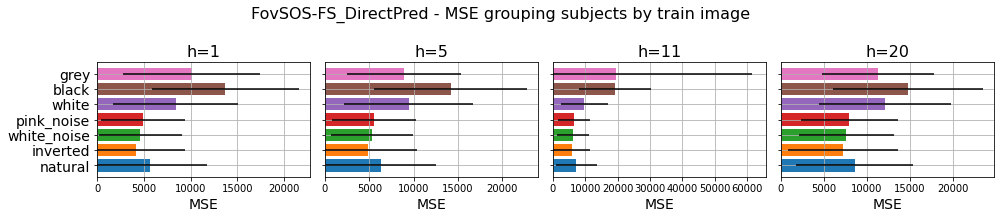

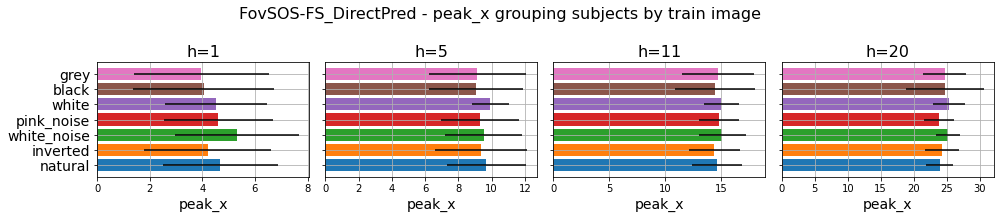

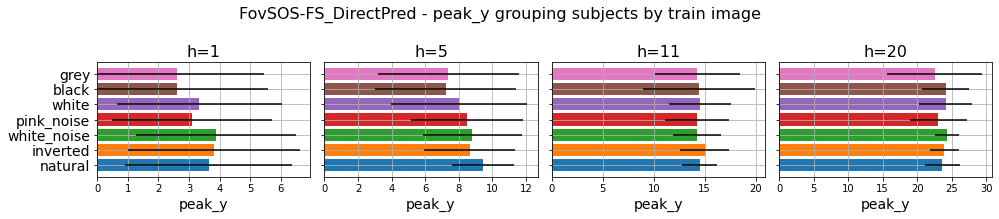

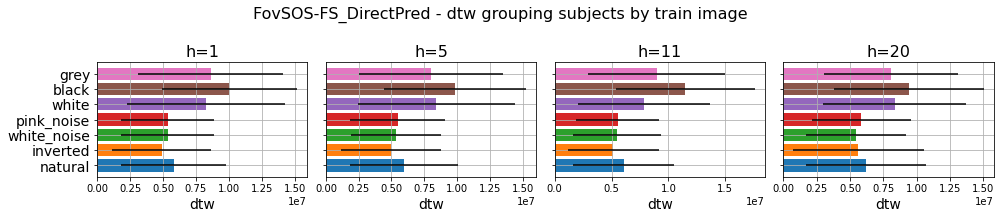

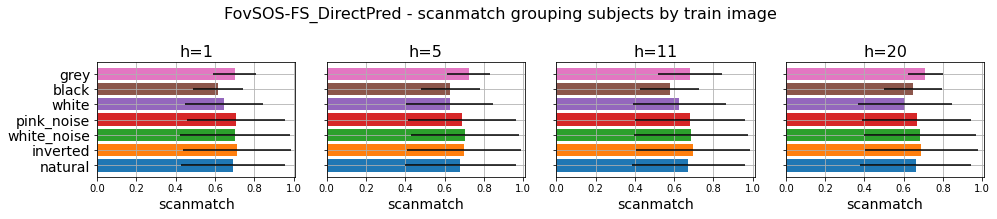

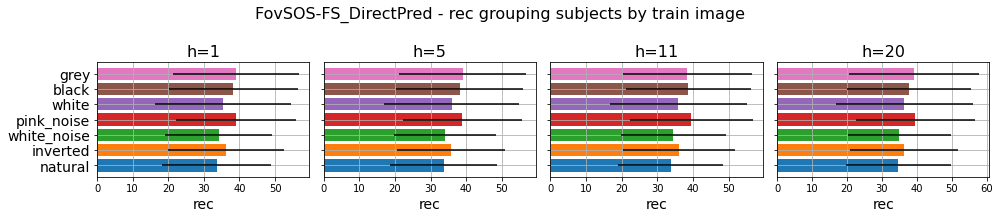

In [23]:
plot_metrics(
    all_results=all_results,
    metrics=["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "rec"],
    kind="bar",
    grouped_by="groupedTrain",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=True,
    **{
        "sharex": False,
        "sharey": True,
        "x_lim_left": {
            "all": 0
        },
        "x_lim_right": {
            "scanmatch": 1.01,
        }
    }
)

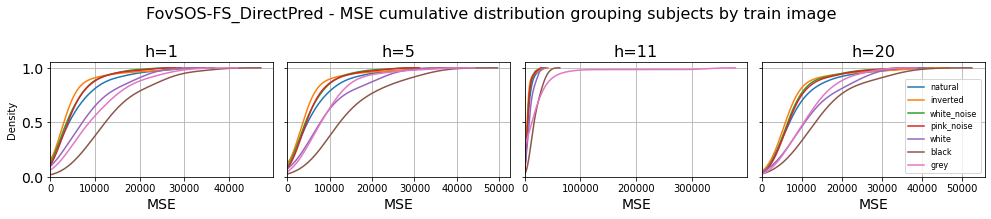

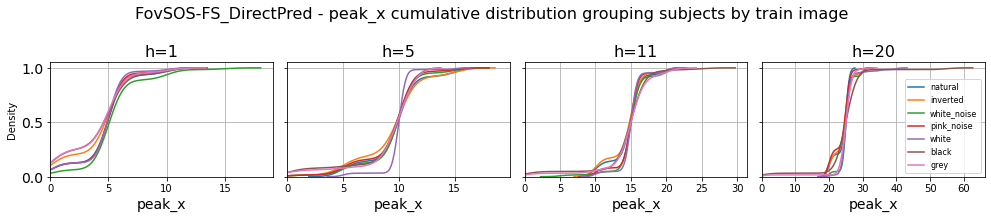

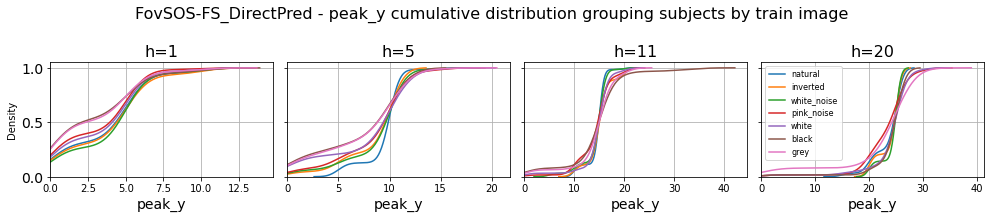

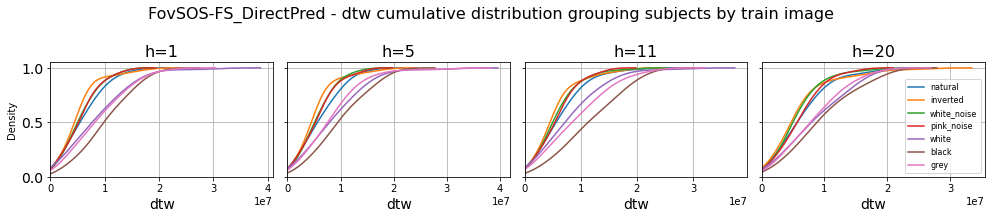

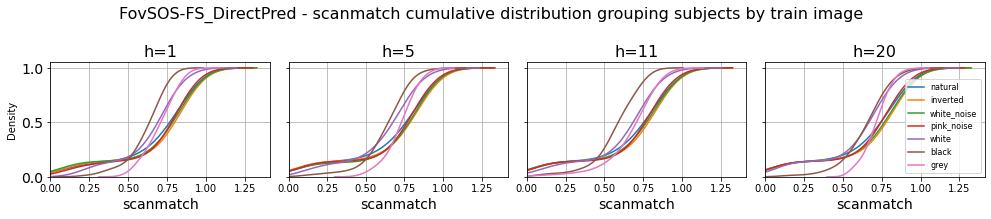

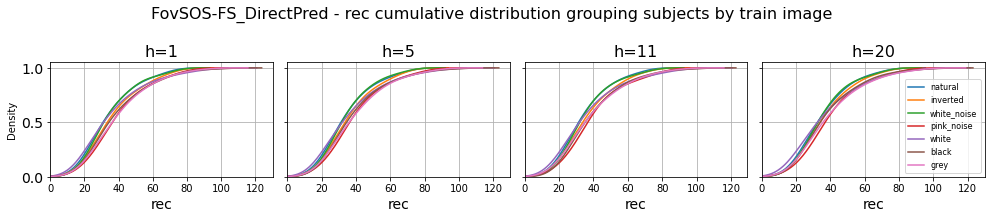

In [24]:
plot_metrics(
    all_results=all_results,
    metrics=["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "rec"],
    kind="cumdist",
    grouped_by="groupedTrain",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": False,
        "sharey": True,
        "x_lim_left": {
            "all": 0
        },
        "x_lim_right": {
            #"MSE": 1e6
        }
    }
)

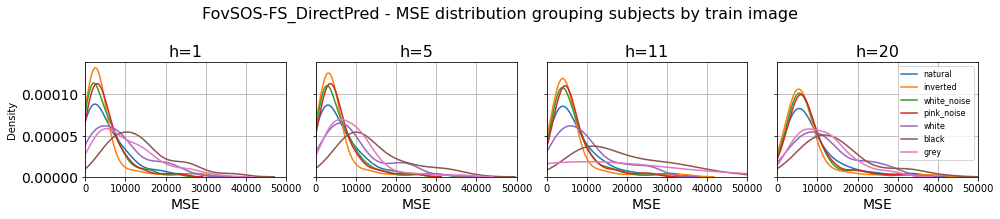

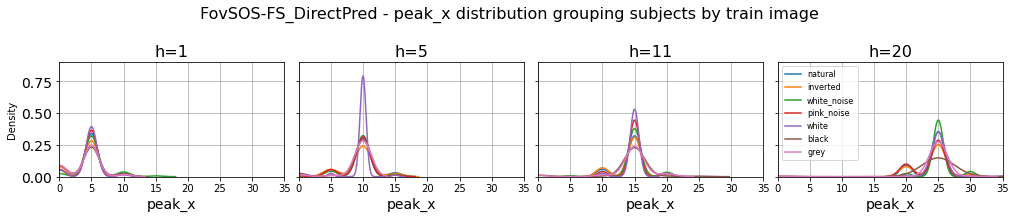

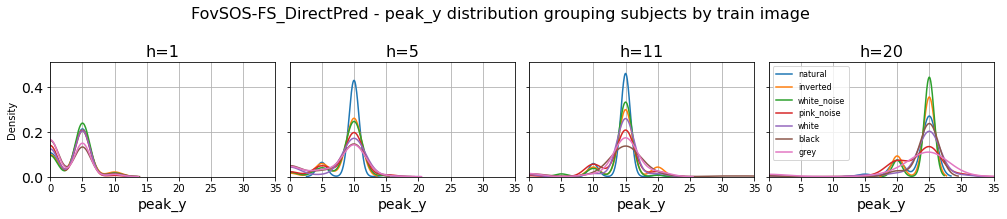

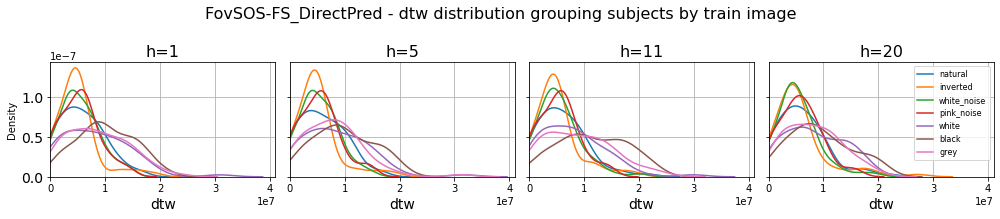

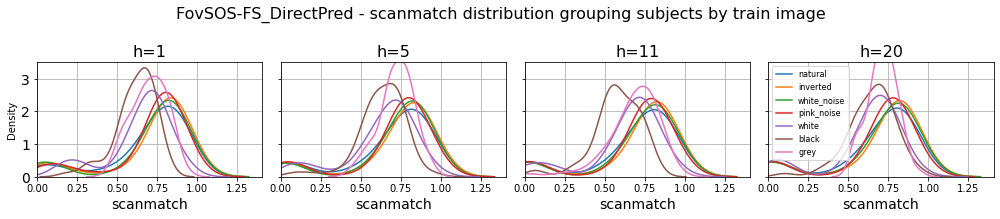

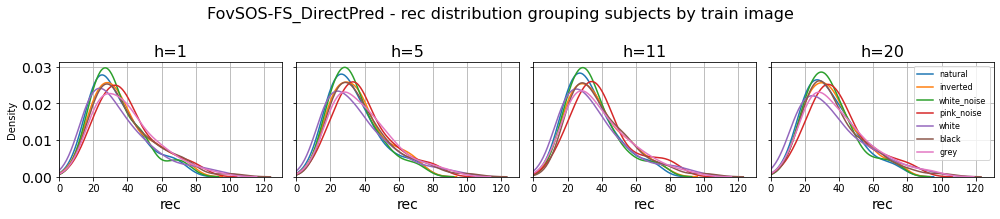

In [25]:
plot_metrics(
    all_results=all_results,
    metrics=["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "rec"],
    kind="dist",
    grouped_by="groupedTrain",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": True,
        "sharey": True,
        "x_lim_left": {
            "all": 0
        },
        "x_lim_right": {
            "MSE": 5e4,
            "peak_x": 35,
            "peak_y": 35
        },
        "y_lim_top": {
            "peak_x": 0.9,
            "peak_y": 0.51
        }
    }
)

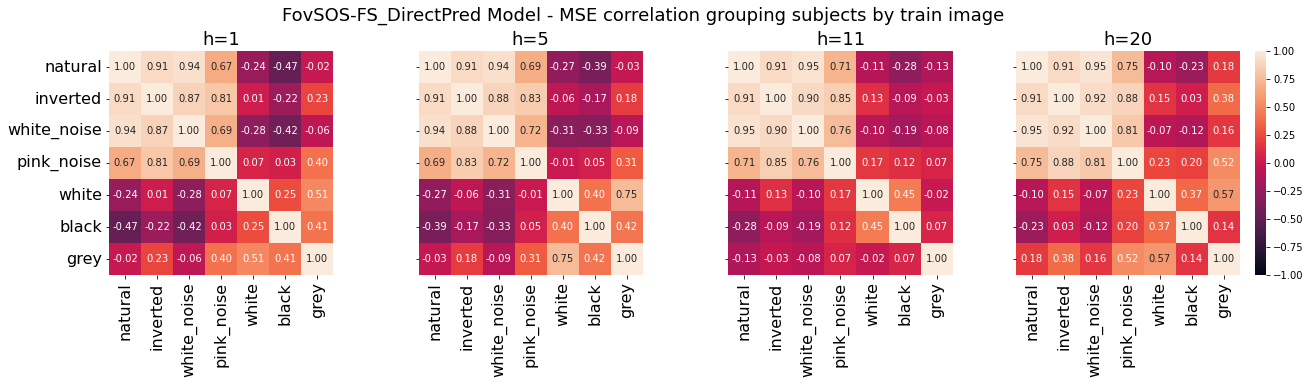

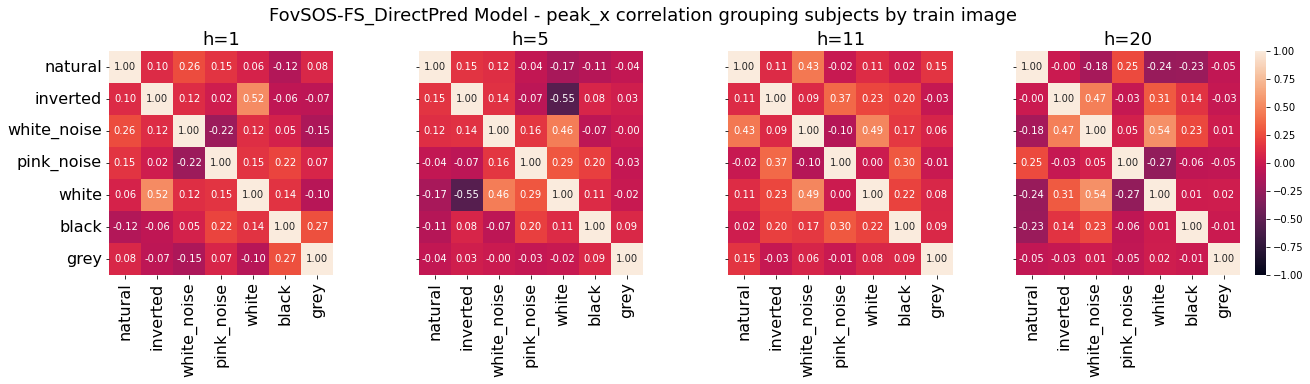

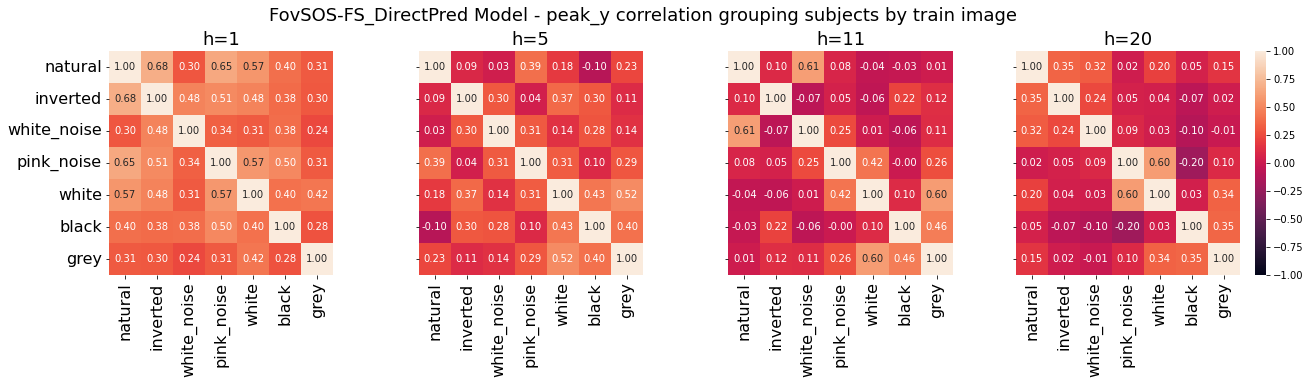

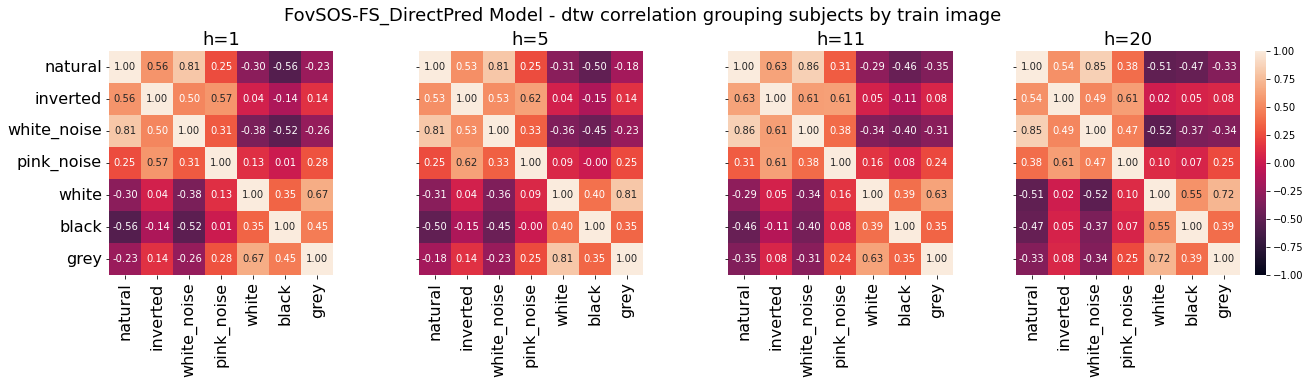

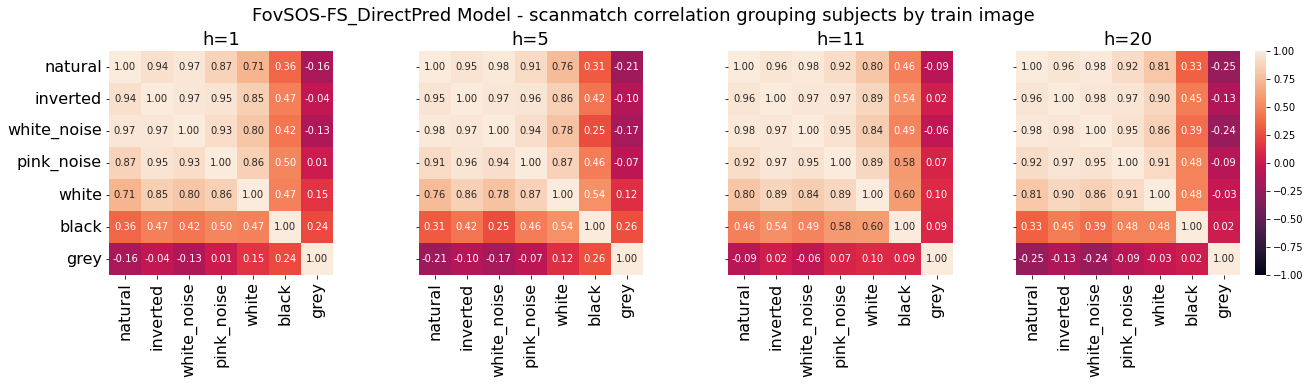

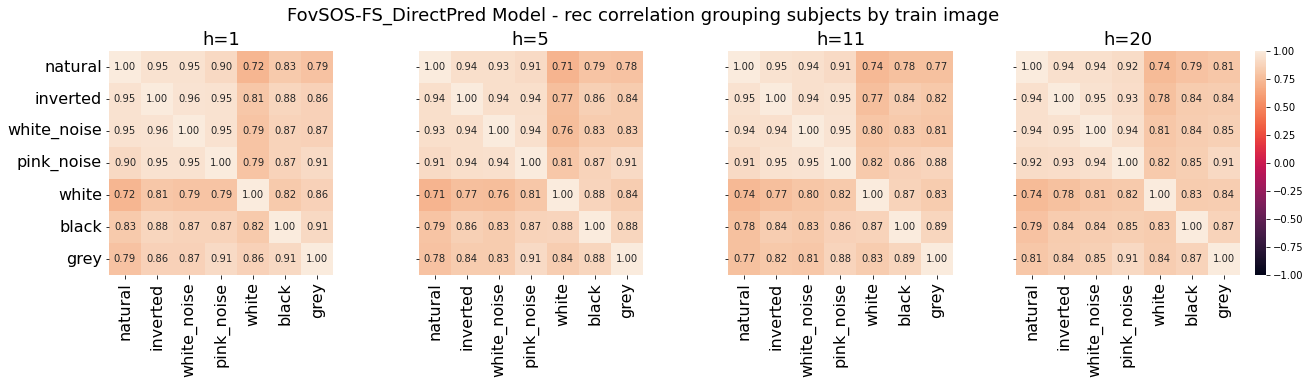

In [61]:
plot_corrs(
    all_results=all_results,
    metrics=["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "rec"],
    grouped_by="groupedTrain",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": False,
        "sharey": True
    }
)

### multimatch by train

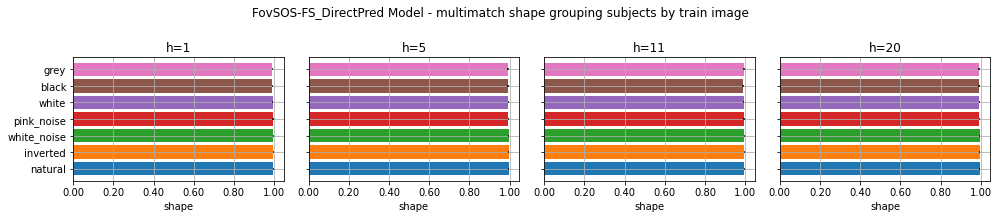

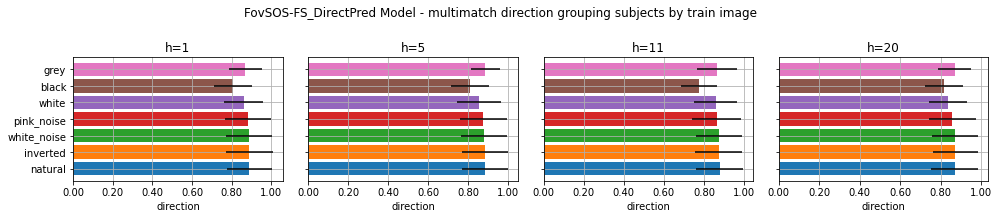

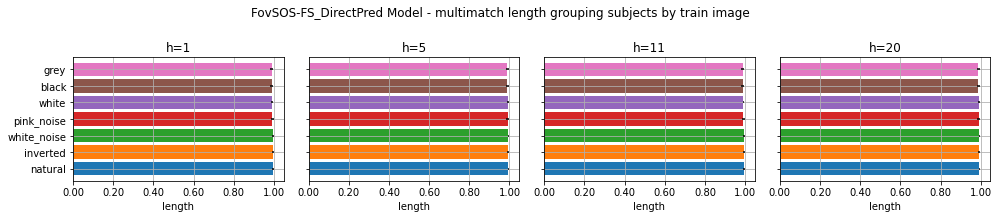

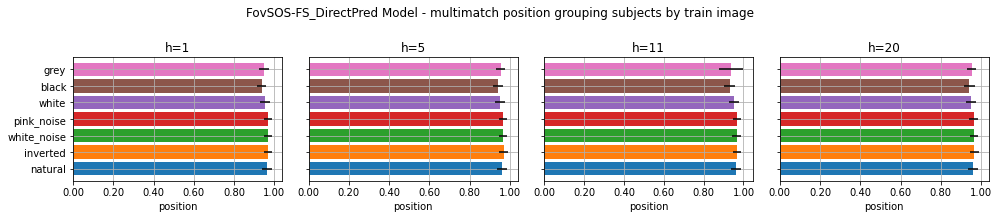

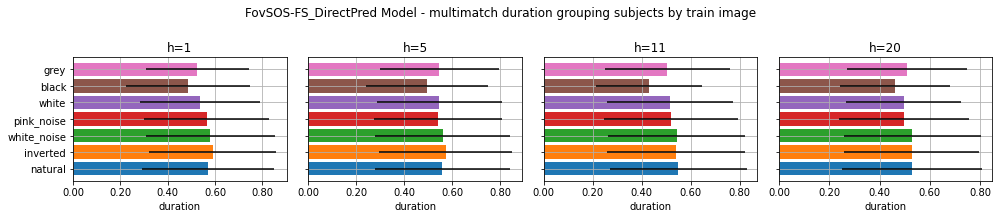

In [27]:
plot_metrics_mm(
    all_results=all_results,
    MULTIMATCH_DIMS=["shape", "direction", "length", "position", "duration"],
    kind="bar",
    grouped_by="groupedTrain",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": False,
        "sharey": True,
        "x_lim_left": {
            "all": 0
        }
    }
)

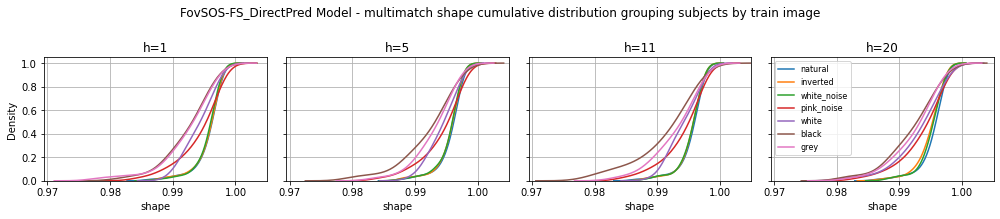

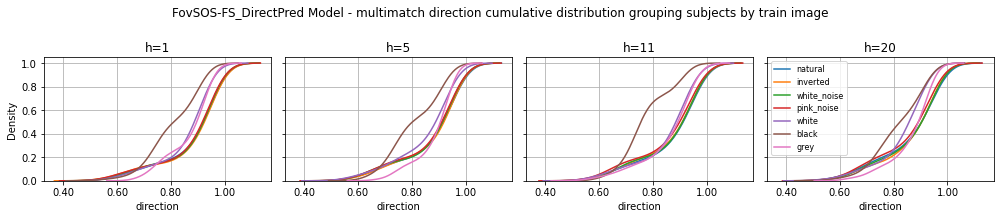

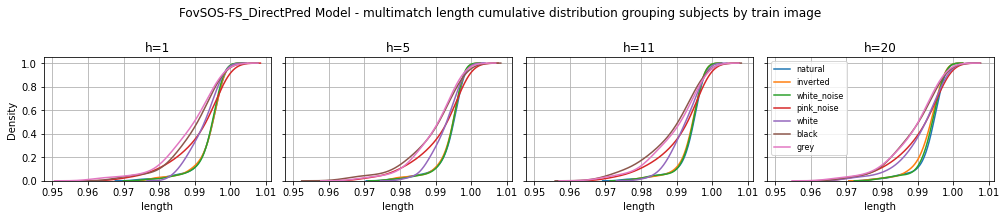

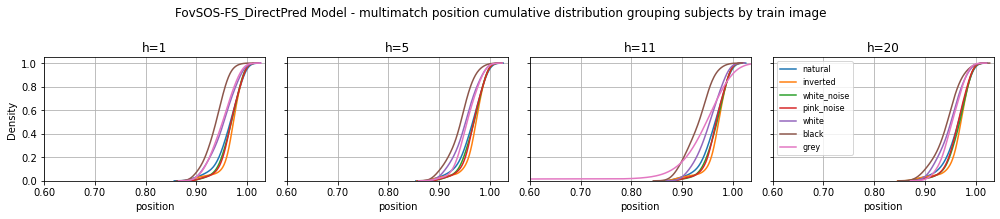

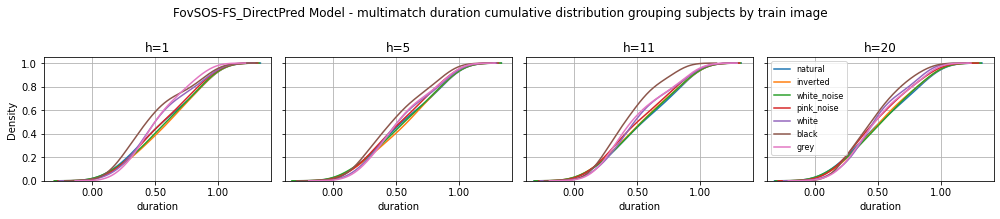

In [28]:
plot_metrics_mm(
    all_results=all_results,
    MULTIMATCH_DIMS=["shape", "direction", "length", "position", "duration"],
    kind="cumdist",
    grouped_by="groupedTrain",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": True,
        "sharey": True,
        "x_lim_left": {
            "position": 0.6
        }
    }
)

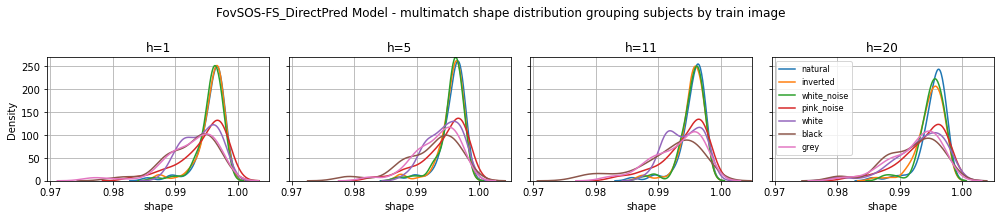

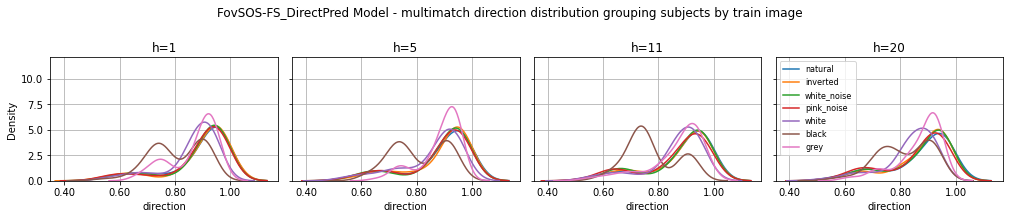

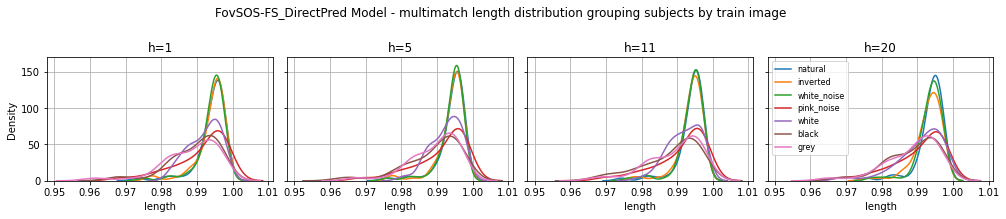

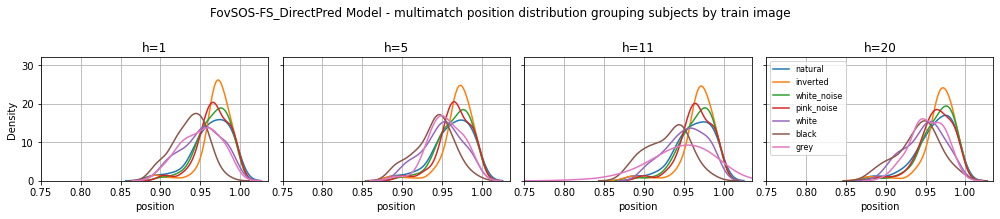

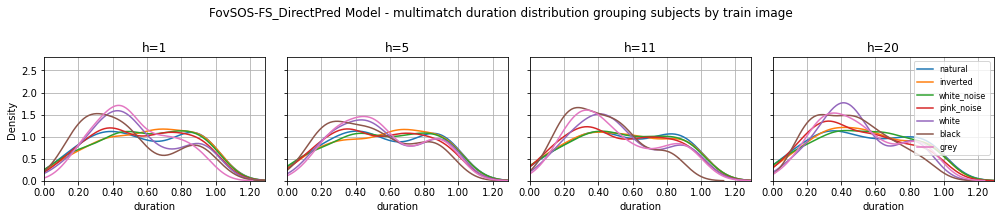

In [29]:
plot_metrics_mm(
    all_results=all_results,
    MULTIMATCH_DIMS=["shape", "direction", "length", "position", "duration"],
    kind="dist",
    grouped_by="groupedTrain",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": True,
        "sharey": True,
        "x_lim_left": {
            "direction": 0.35,
            "position": 0.75,
            "length": 0.948,
            "duration": 0
        },
        "x_lim_right": {
            "duration": 1.29
        },
        "y_lim_top": {
            "shape": 270,
            "direction": 12.1,
            "length": 170,
            "position": 32,
            "duration": 2.8
        }
    }
)

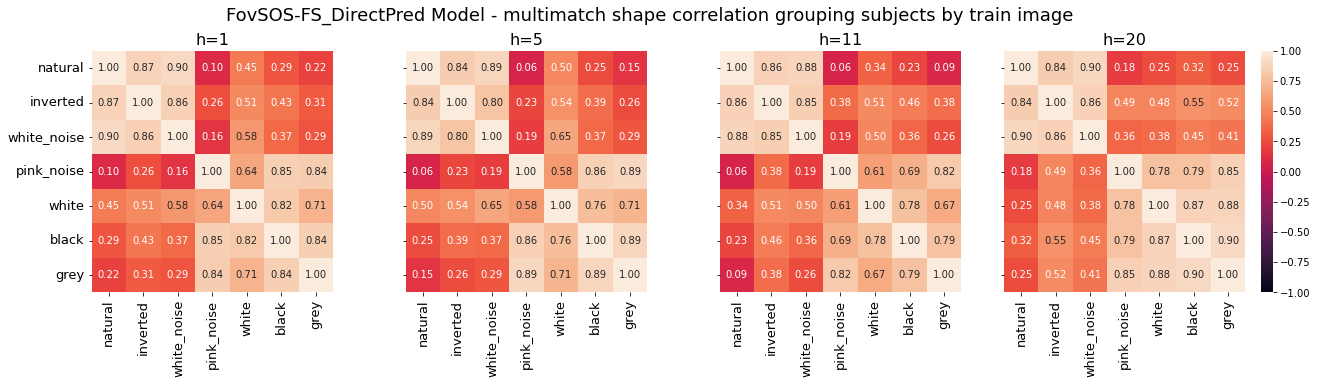

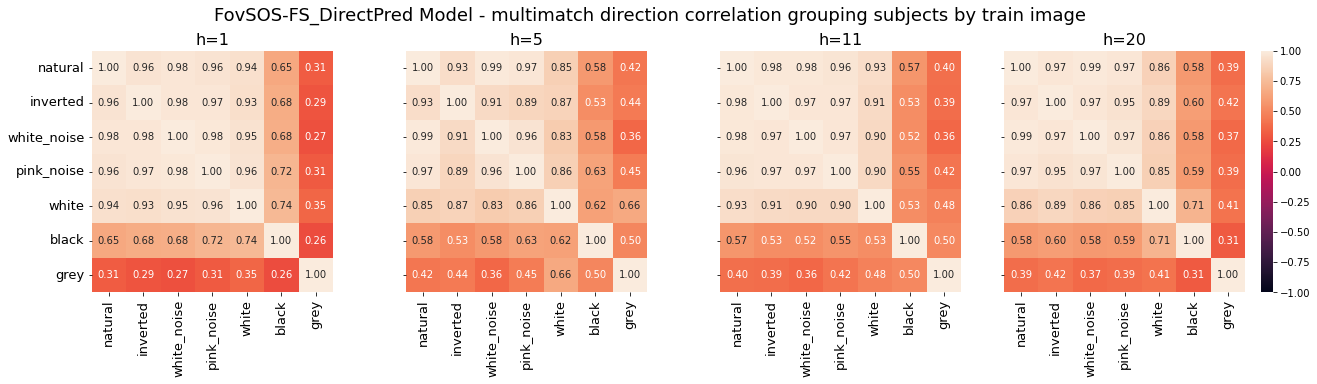

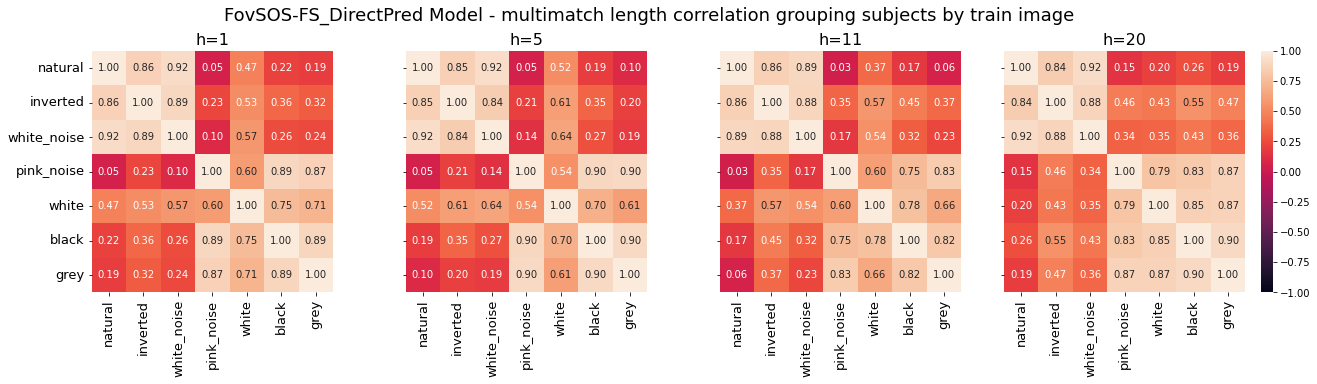

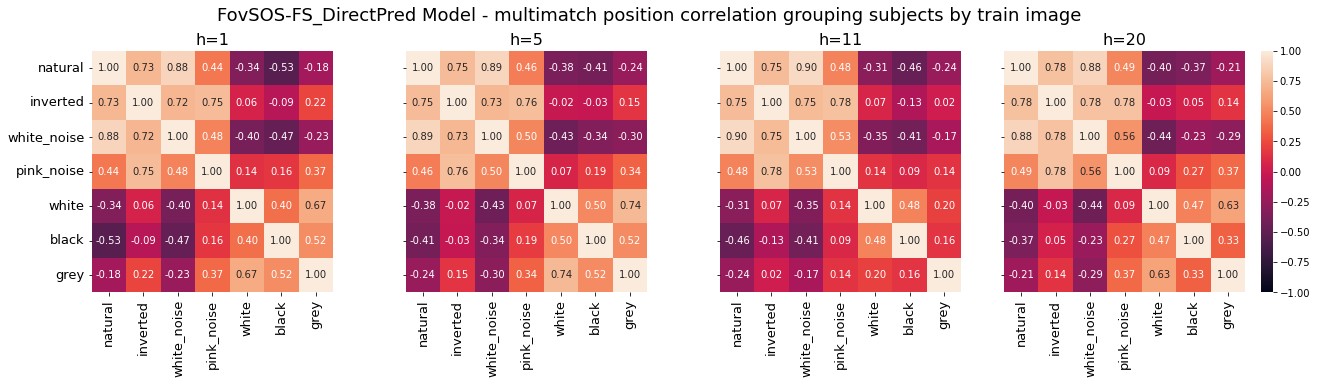

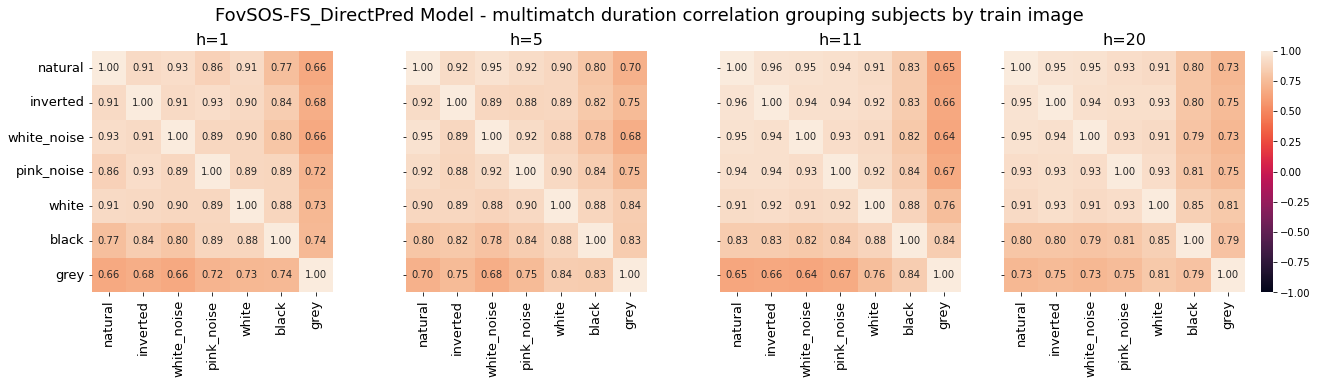

In [30]:
plot_corrs_mm(
    all_results=all_results,
    MULTIMATCH_DIMS=["shape", "direction", "length", "position", "duration"],
    grouped_by="groupedTrain",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": False,
        "sharey": True
    }
)

### Correlations by train

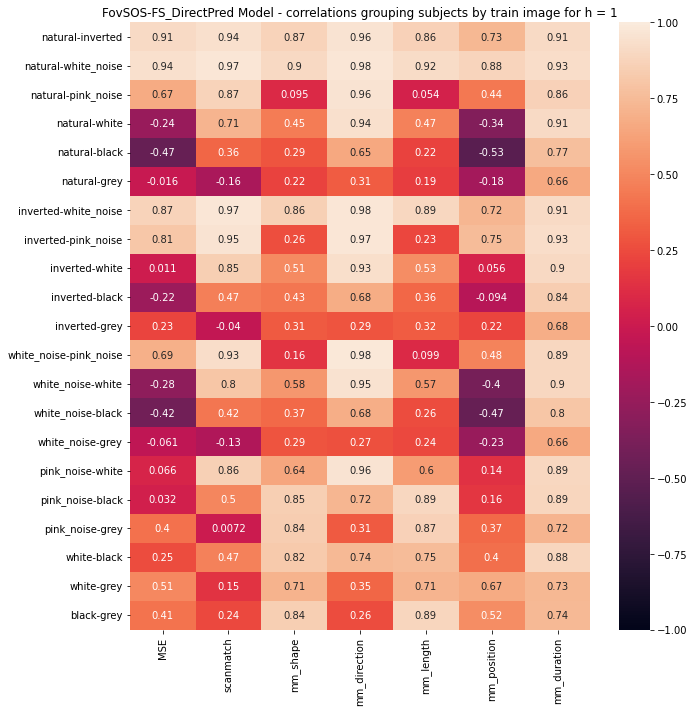

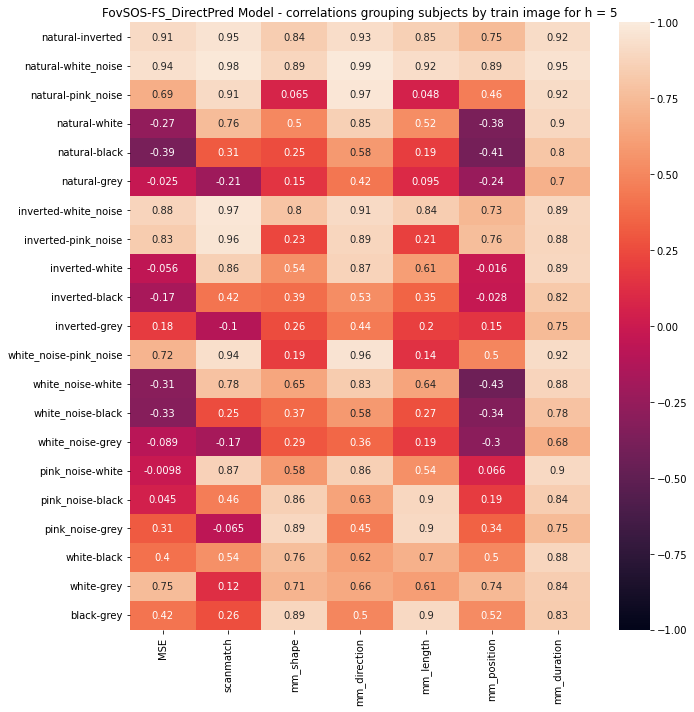

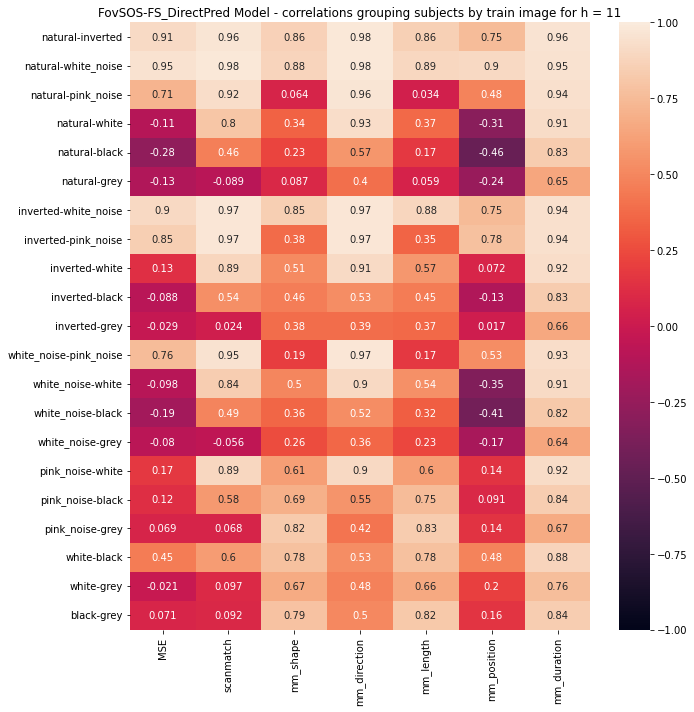

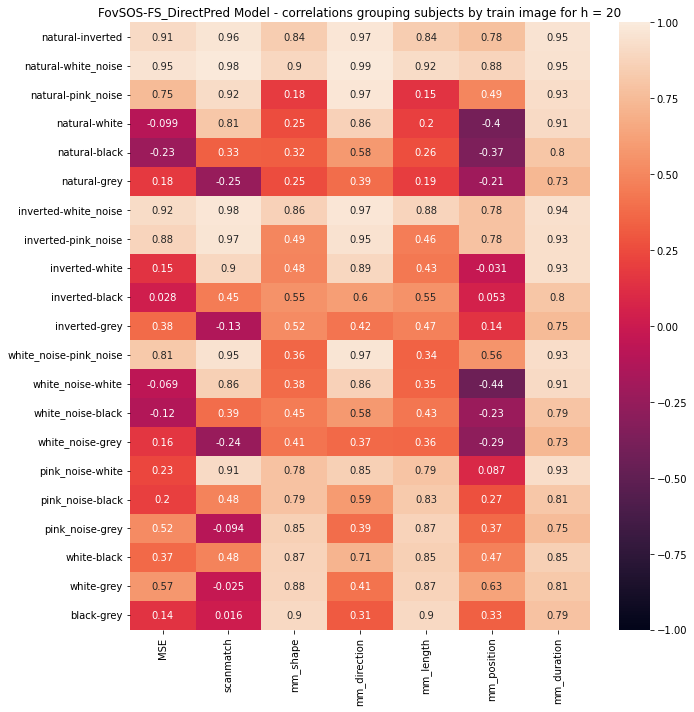

In [31]:
correlations_horizon = {}
for i, h in enumerate([1, 5, 11, 20]):
    correlations = {}
    #for metric in ["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "multimatch"]:
    #for metric in ["MSE", "peak_x", "peak_y", "scanmatch", "multimatch"]:
    for metric in ["MSE", "scanmatch", "multimatch"]:
    #for metric in ["multimatch"]:
        N, Nt = horizons[h][model_name]
        df = searcher.get_results_by_query(all_results, 
                         metric=metric, 
                         subject=None, 
                         tIMG=None, 
                         N=N,
                         Nt=Nt,
                         predIMG=None
                        )[0].apply(pd.Series)
        metrics_grouped_by_img_type = group_metrics(df, group_img_type="tIMG")
        if (metrics_grouped_by_img_type.std() == 0).any():
            df_loc = metrics_grouped_by_img_type.loc[:, (metrics_grouped_by_img_type.std() == 0)] 
            for i_col in df_loc.columns:
                metrics_grouped_by_img_type[i_col] += np.random.randn(len(df_loc)) * 1e-2
        metrics_used = metrics_grouped_by_img_type.index.get_level_values(0).unique()
        if len(metrics_used) > 1:
            for u, m_u in enumerate(metrics_used):
                corrs = metrics_grouped_by_img_type.loc[m_u].corr()
                if metric == "multimatch":
                    correlations[f"mm_{MULTIMATCH_DIMS[u]}"] = corrs
                else:
                    correlations[f"{metric}_{u}"] = corrs
        else:
            corrs = metrics_grouped_by_img_type.loc["metric_0"].corr()
            correlations[metric] = corrs
    correlations_horizon[h] = pd.concat(correlations)

    distributions = {}
    for i, p_img_type in enumerate(IMG_TYPES):
        for q_img_type in IMG_TYPES[i+1:]:
            dist = pd.concat(correlations_horizon).loc[h].loc[:, p_img_type][:, q_img_type]
            distributions[f"{p_img_type}-{q_img_type}"] = dist.to_frame().T

    df_distributions = pd.concat(distributions).droplevel(1)
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    sns.heatmap(df_distributions, ax=ax, annot=True, vmin=-1, vmax=1)
    ax.set_title(f"{model_name} Model - correlations grouping subjects by train image for h = {h}")
    fig.tight_layout()
    if is_save:
        savepath = os.path.join(SAVE_FOLDER, f"general/grouped/")
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        fig.savefig(f"{os.path.join(savepath, f'correlations_{h}_groupedTrain')}.png")
    plt.show()
    plt.show()

## Group by predicted image

### MSE, peaks by predicted

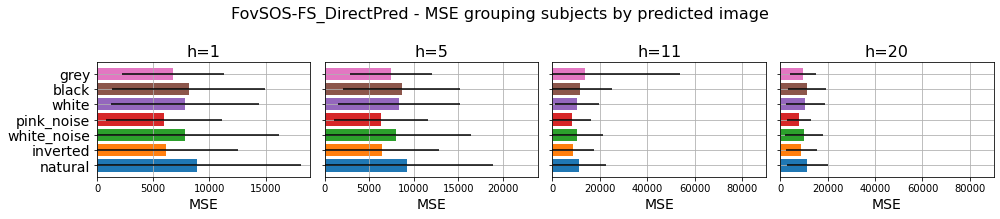

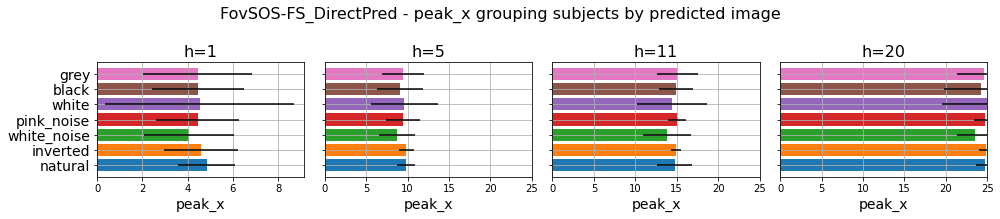

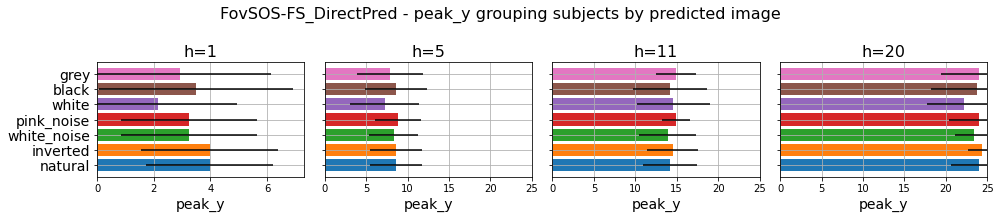

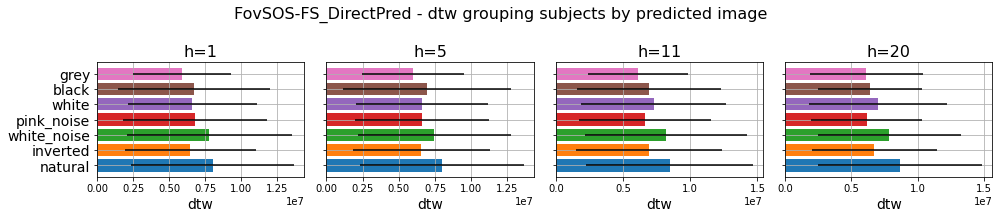

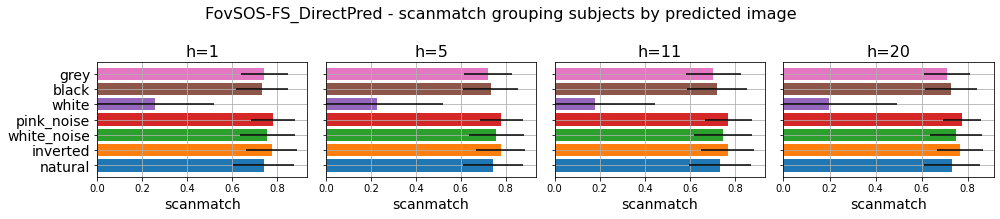

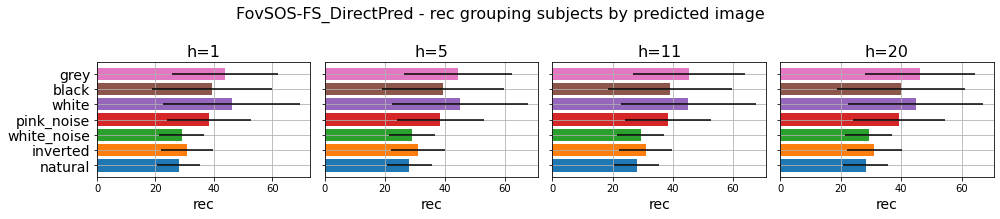

In [32]:
plot_metrics(
    all_results=all_results,
    metrics=["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "rec"],
    kind="bar",
    grouped_by="groupedPredicted",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": False,
        "sharey": True,
        "x_lim_left": {
            "all": 0
        },
        "x_lim_right": {
            "MSE": {
                1: 19000,
                5: 24000,
                11: 9e4,
                20: 9e4,
            },
            "peak_x": {
                1: None,
                5: 25,
                11: 25,
                20: 25
            },
            "peak_y": {
                1: None,
                5: 25,
                11: 25,
                20: 25
            }
        }
    }
)

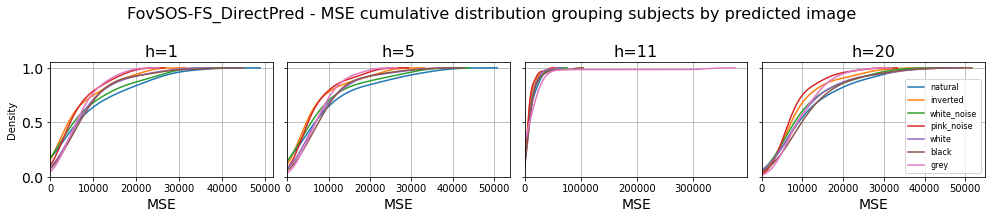

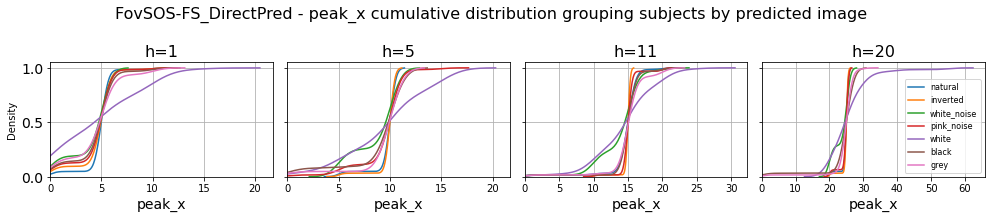

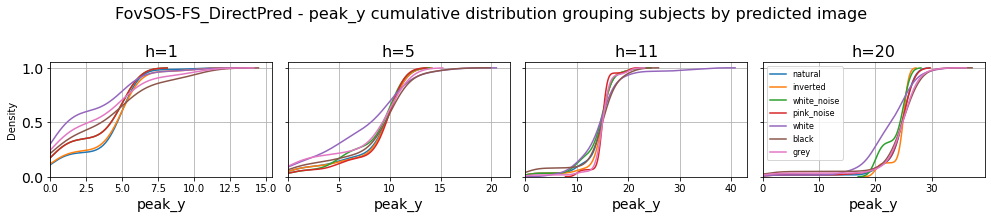

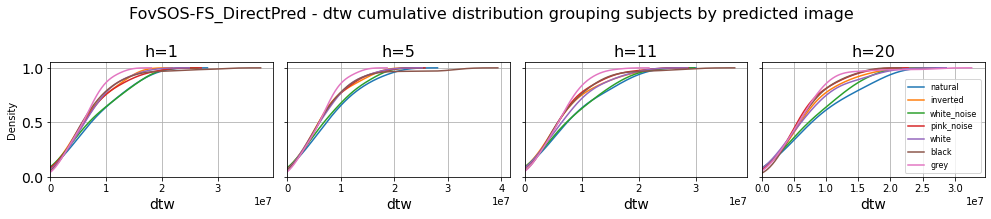

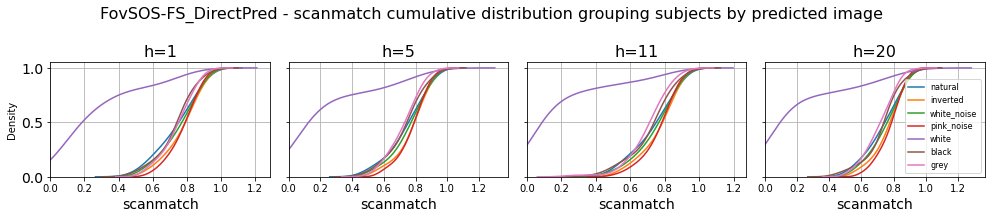

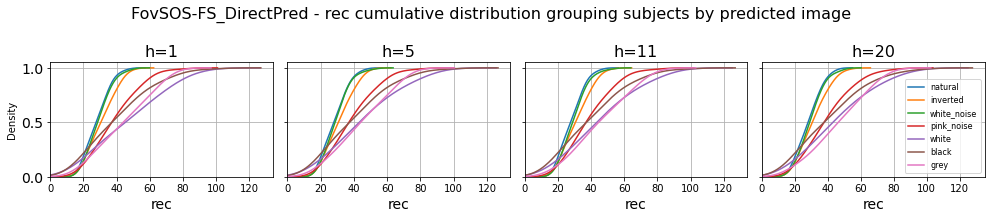

In [33]:
plot_metrics(
    all_results=all_results,
    metrics=["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "rec"],
    kind="cumdist",
    grouped_by="groupedPredicted",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": False,
        "sharey": True,
        "x_lim_left": {
            "all": 0
        },
        #"x_lim_right_MSE":1e4
    }
)

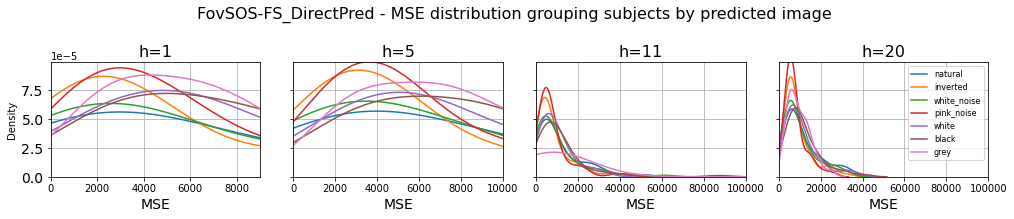

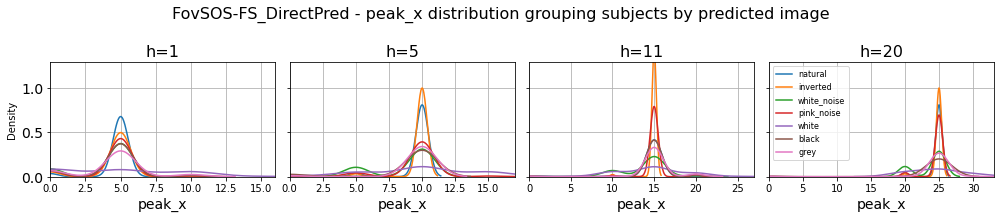

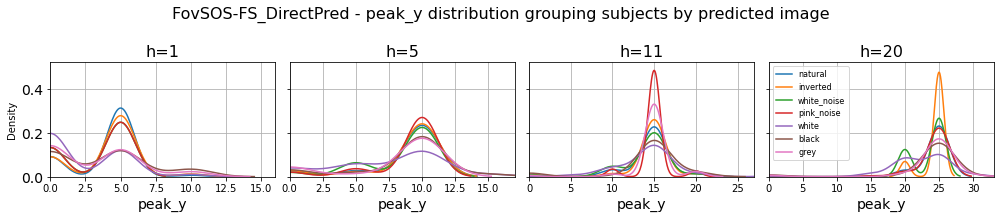

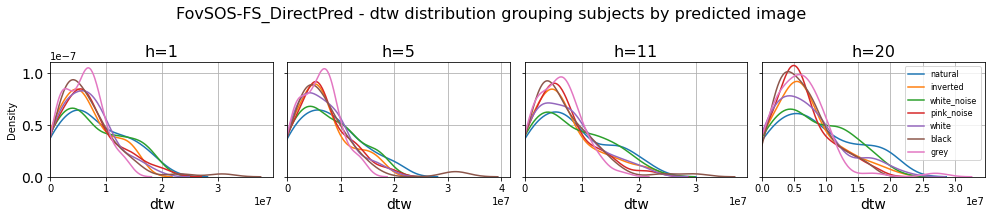

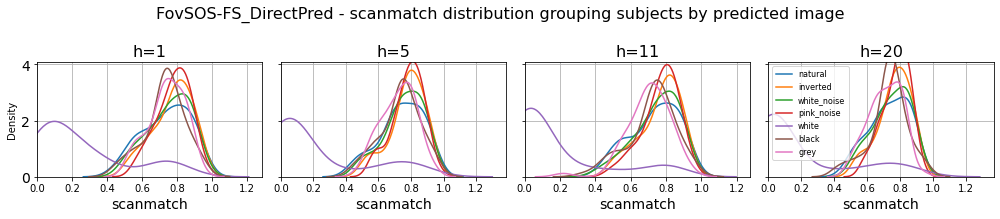

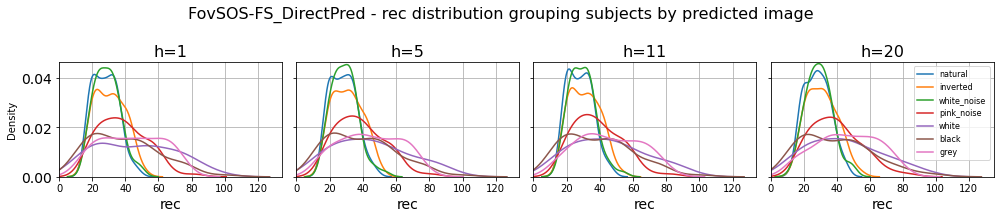

In [34]:
plot_metrics(
    all_results=all_results,
    metrics=["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "rec"],
    kind="dist",
    grouped_by="groupedPredicted",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": False,
        "sharey": True,
        "x_lim_left": {
            "all": 0
        },
        "x_lim_right": {
            "MSE": {
                1: 9e3,
                5: 1e4,
                11: 1e5,
                20: 1e5
            },
            "peak_x": {
                1: 16,
                5: 17,
                11: 27,
                20: 33
            },
            "peak_y": {
                1: 16,
                5: 17,
                11: 27,
                20: 33
            }
        },
        "y_lim_top":{
            "peak_x": 1.29,
            "peak_y": 0.52
        },
    }
)

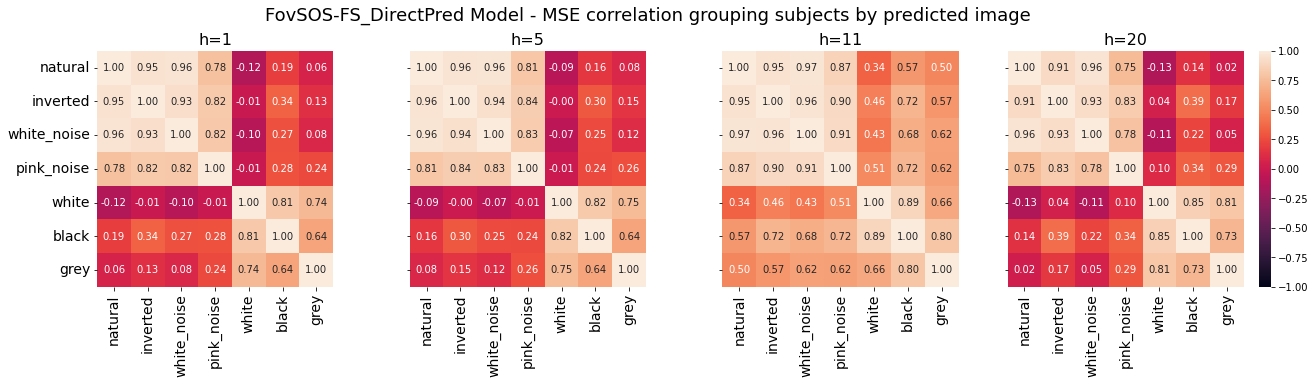

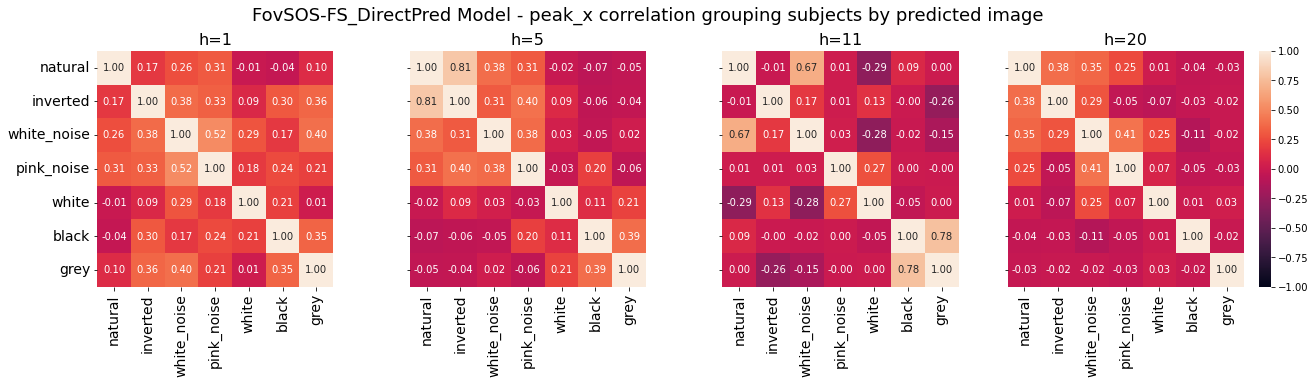

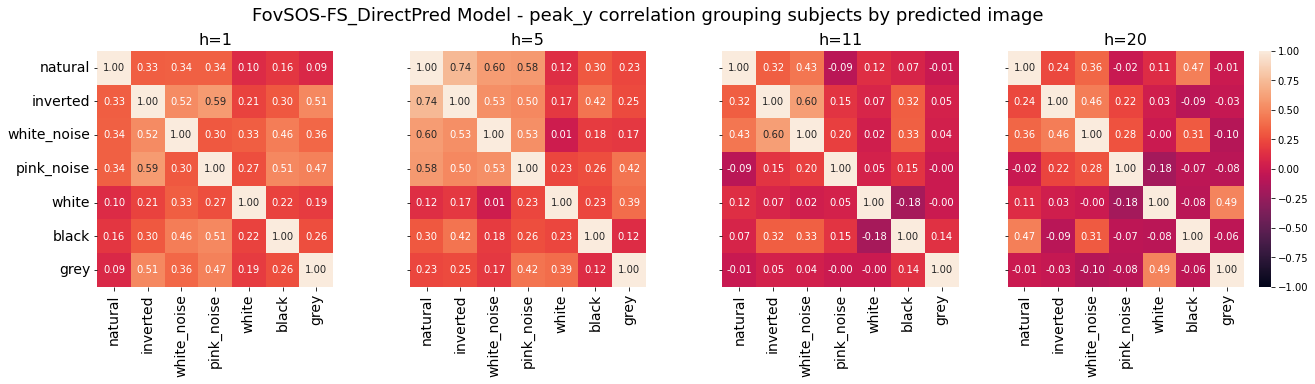

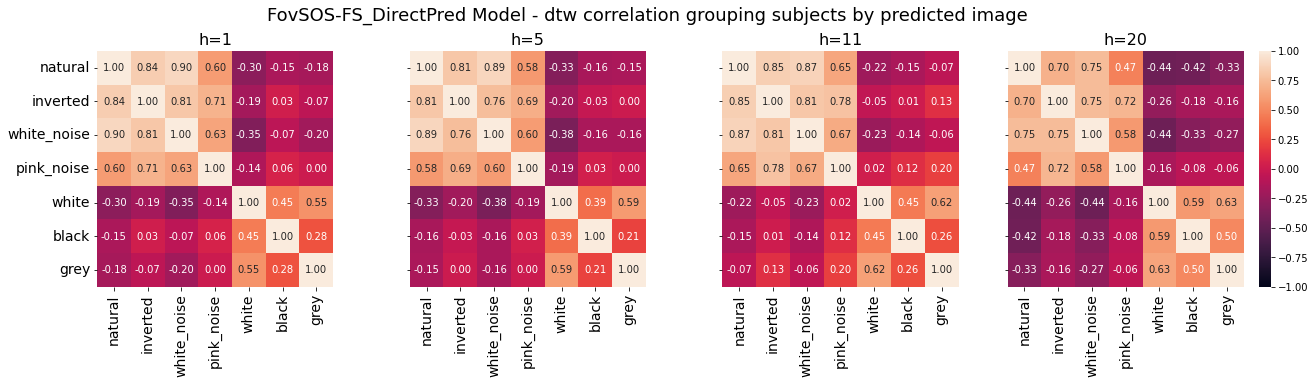

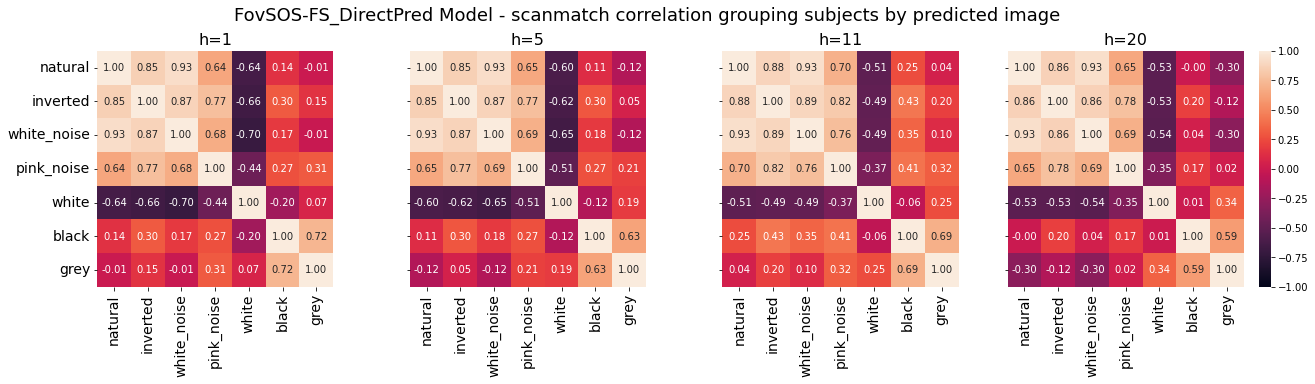

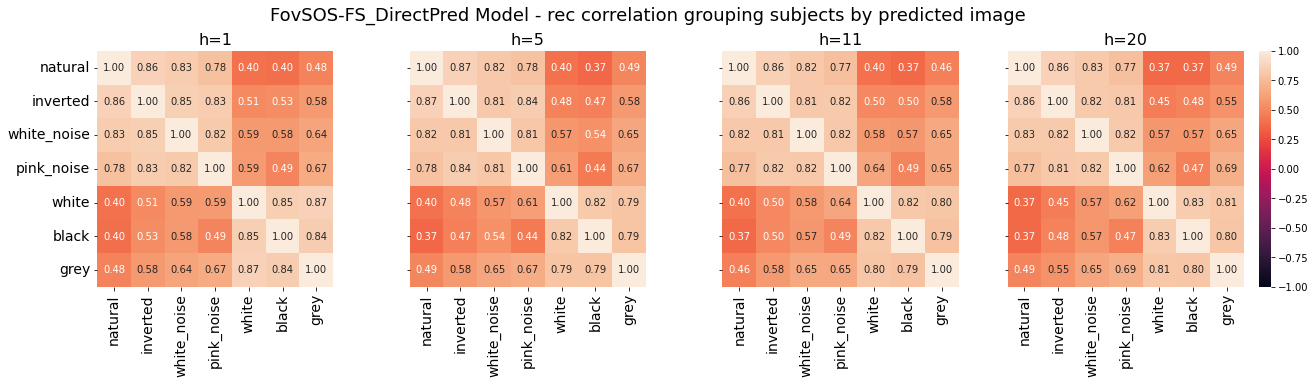

In [35]:
plot_corrs(
    all_results=all_results,
    metrics=["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "rec"],
    grouped_by="groupedPredicted",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": False,
        "sharey": True
    }
)

### multimatch by predicted

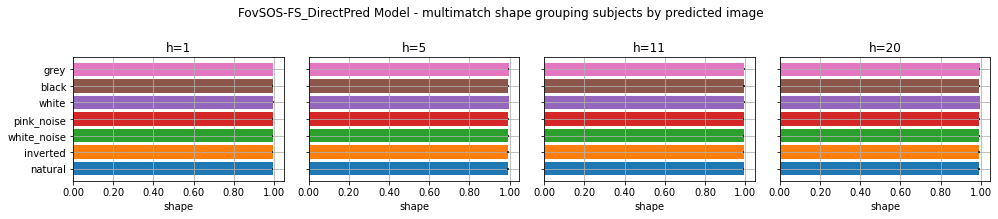

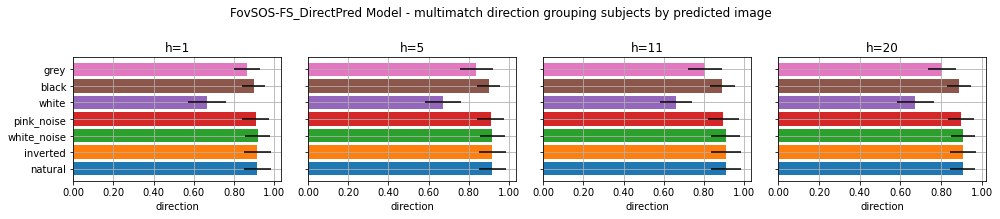

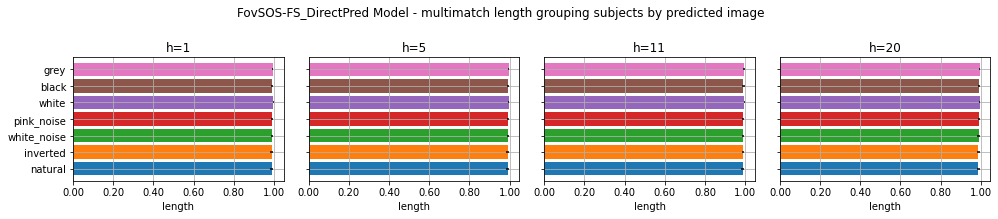

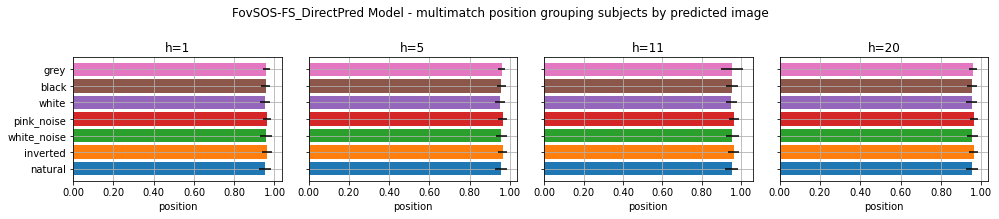

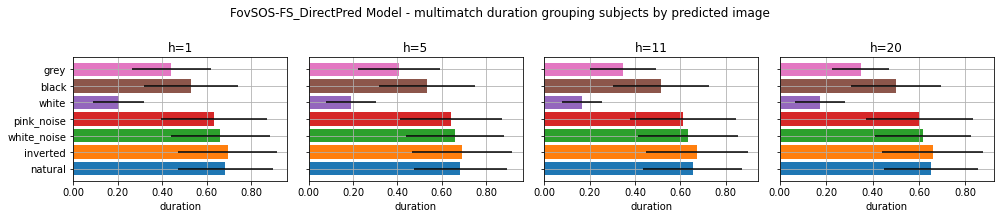

In [36]:
plot_metrics_mm(
    all_results=all_results,
    MULTIMATCH_DIMS=["shape", "direction", "length", "position", "duration"],
    kind="bar",
    grouped_by="groupedPredicted",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": False,
        "sharey": True,
        "x_lim_left": {
            "all": 0
        }
    }
)

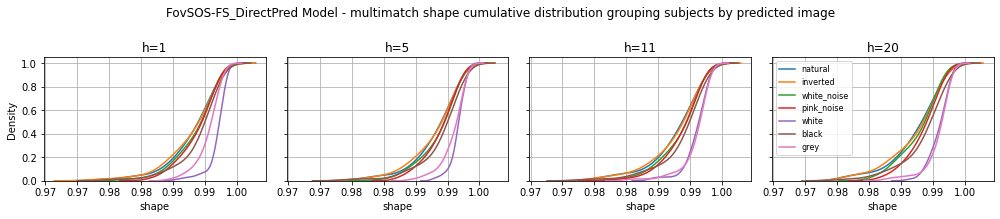

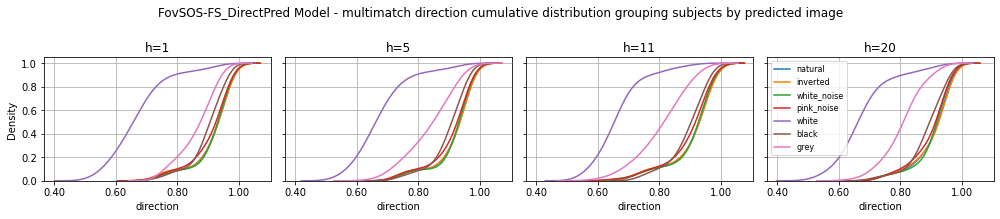

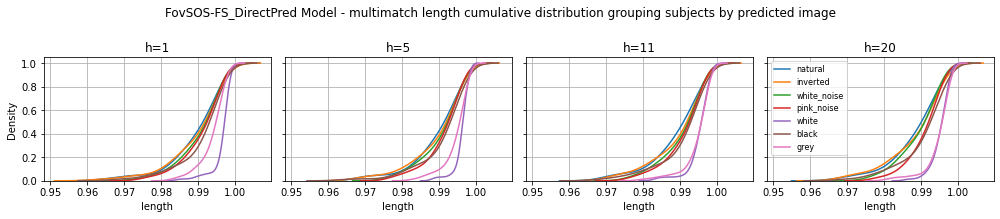

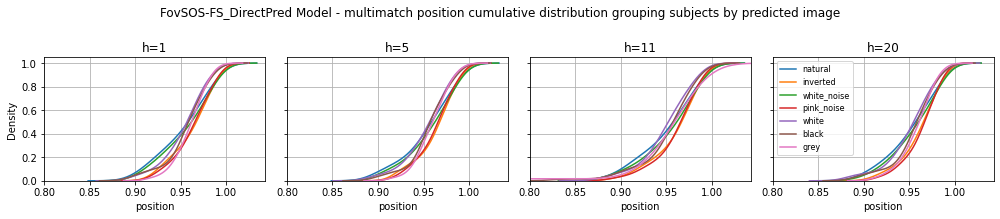

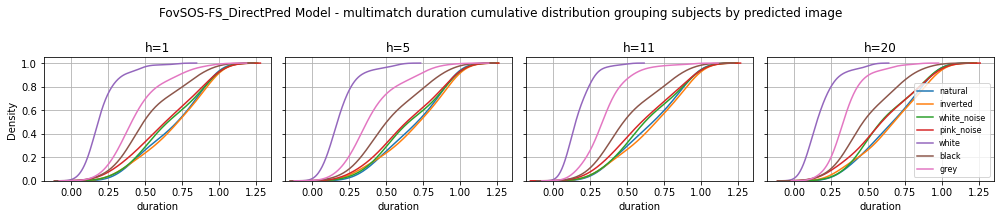

In [37]:
plot_metrics_mm(
    all_results=all_results,
    MULTIMATCH_DIMS=["shape", "direction", "length", "position", "duration"],
    kind="cumdist",
    grouped_by="groupedPredicted",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": True,
        "sharey": True,
        "x_lim_left": {
            "position": 0.8
        }
    }
)

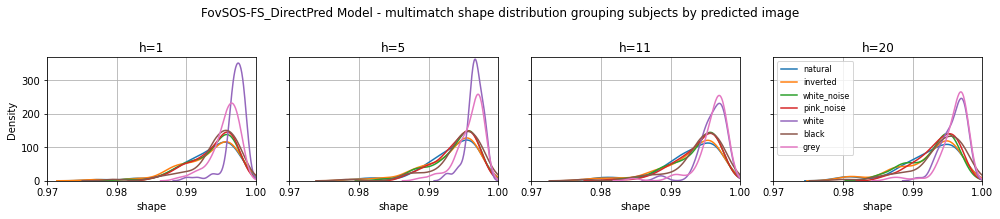

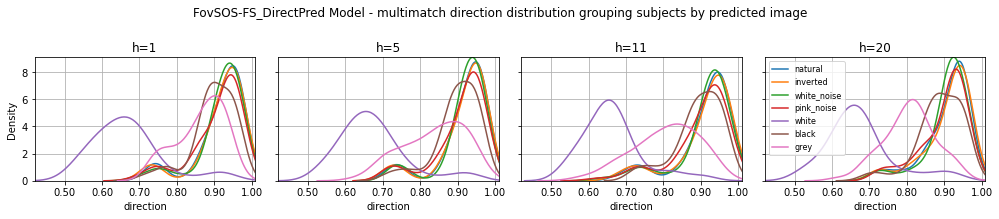

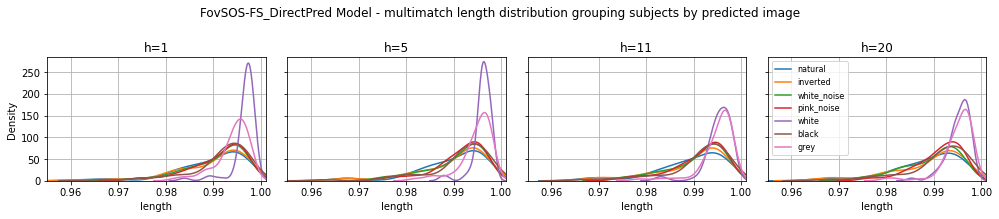

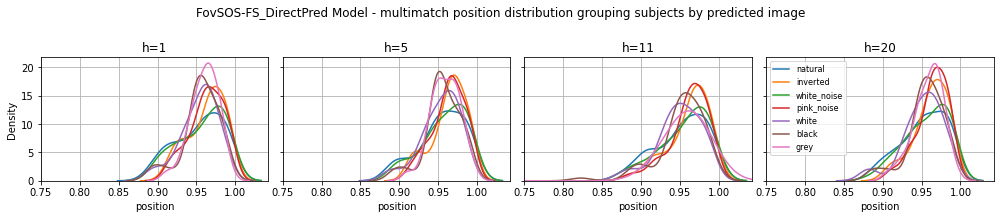

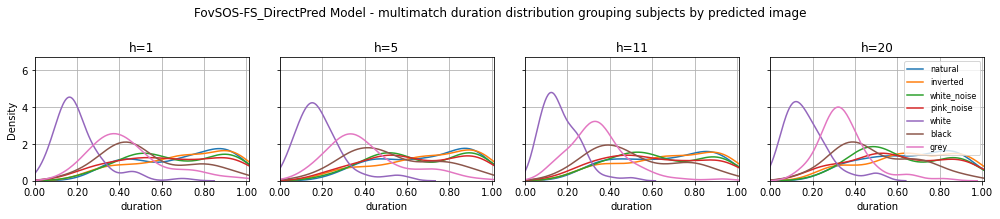

In [38]:
plot_metrics_mm(
    all_results=all_results,
    MULTIMATCH_DIMS=["shape", "direction", "length", "position", "duration"],
    kind="dist",
    grouped_by="groupedPredicted",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": True,
        "sharey": True,
        "x_lim_left": {
            "shape": 0.97,
            "direction": 0.42,
            "length": 0.955,
            "position": 0.75,
            "duration": 0
        },
        "x_lim_right": {
            "shape": 1,
            "direction": 1.01,
            "length": 1.001,
            "duration": 1.01
        },
        "y_lim_top": {
            #"direction": 25,
            "duration": 6.7
        }
    }
)

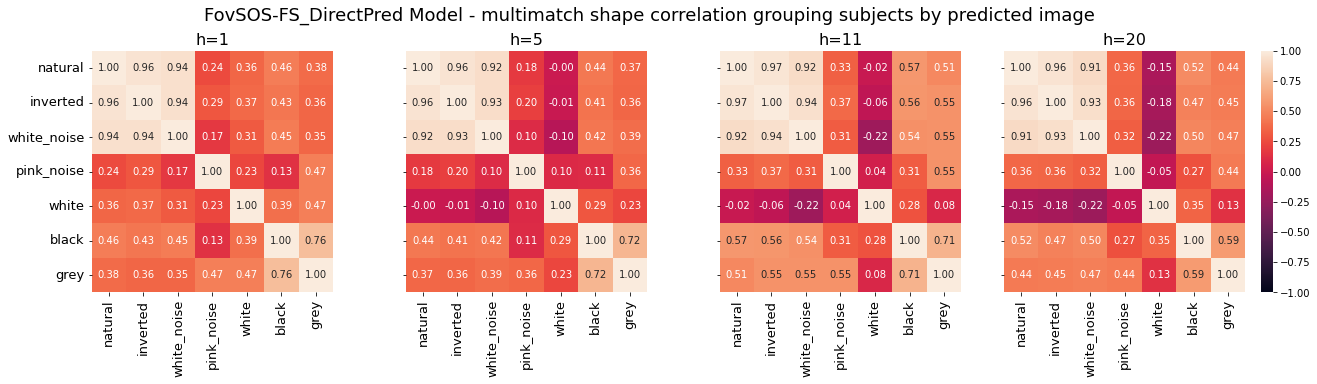

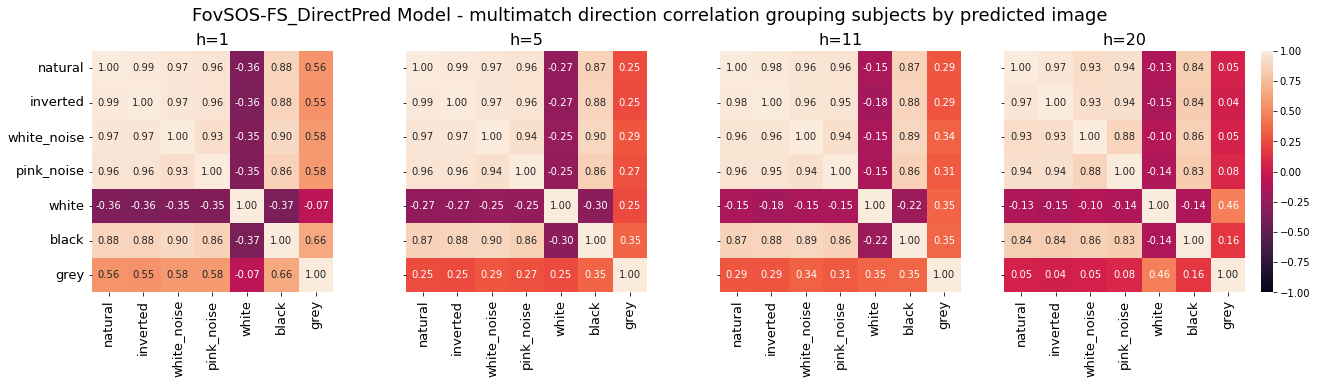

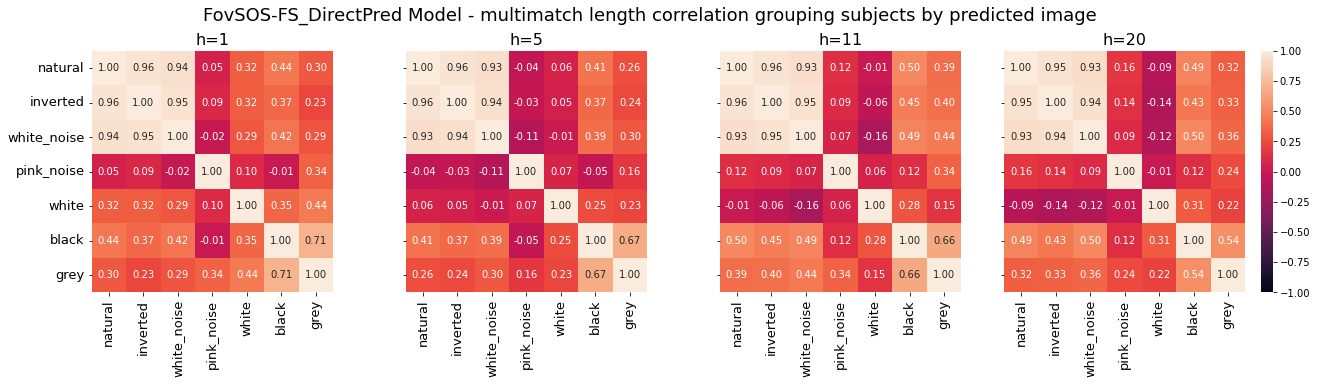

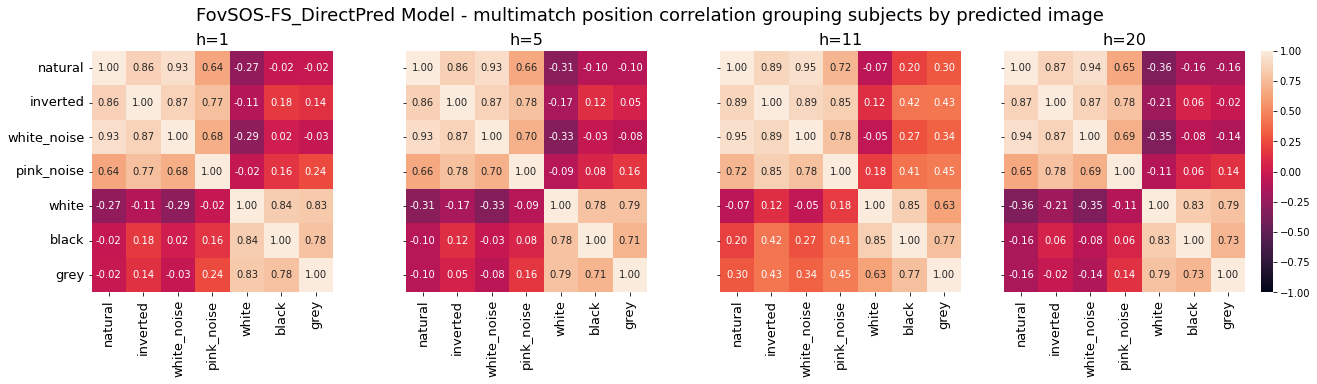

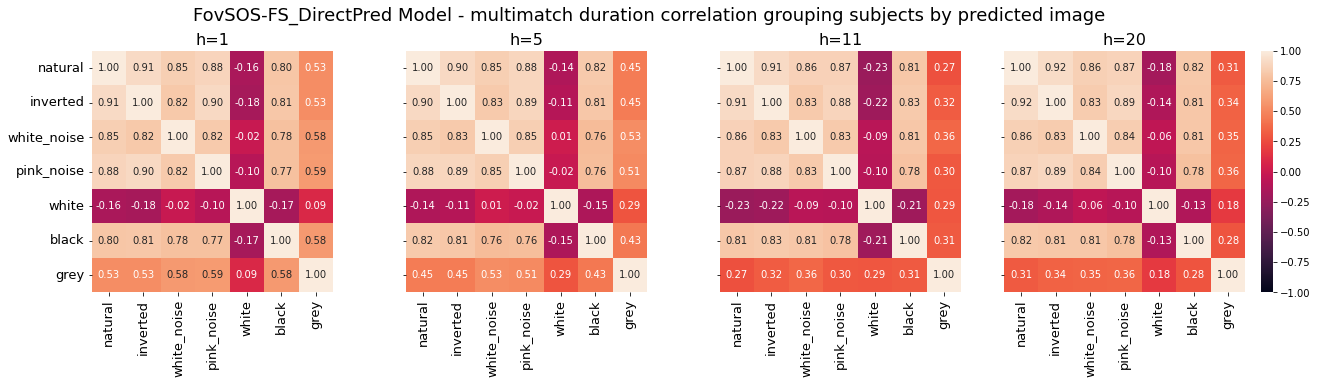

In [39]:
plot_corrs_mm(
    all_results=all_results,
    MULTIMATCH_DIMS=["shape", "direction", "length", "position", "duration"],
    grouped_by="groupedPredicted",
    IMG_TYPES=IMG_TYPES,
    horizons=horizons,
    model_name=model_name,
    is_save=is_save,
    **{
        "sharex": False,
        "sharey": True
    }
)

### Correlations by predicted

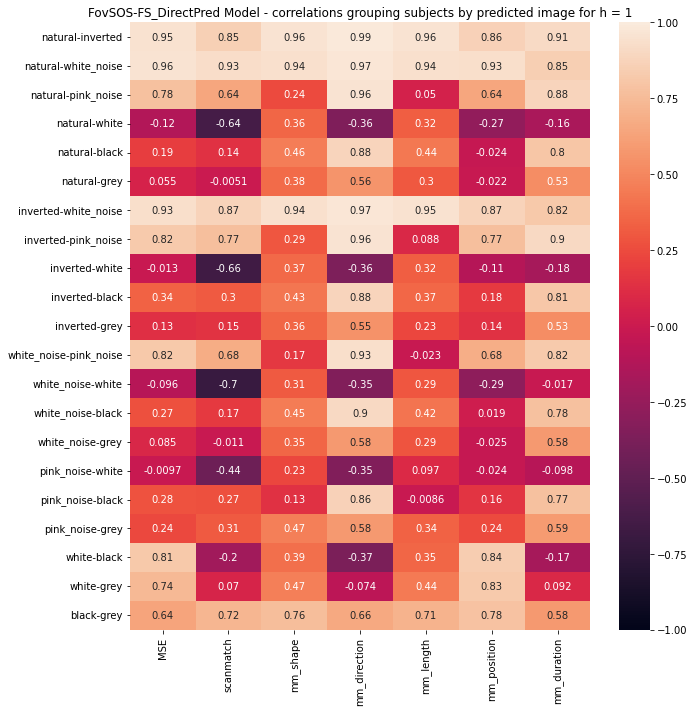

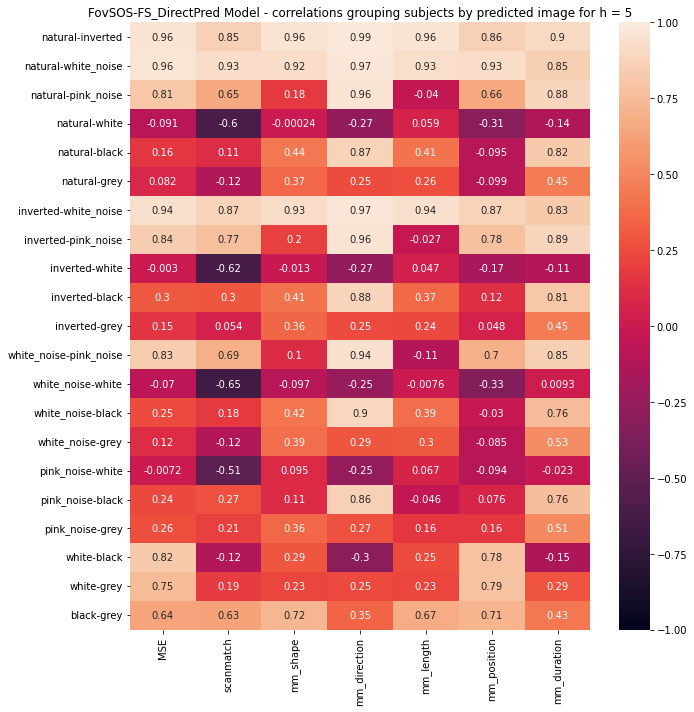

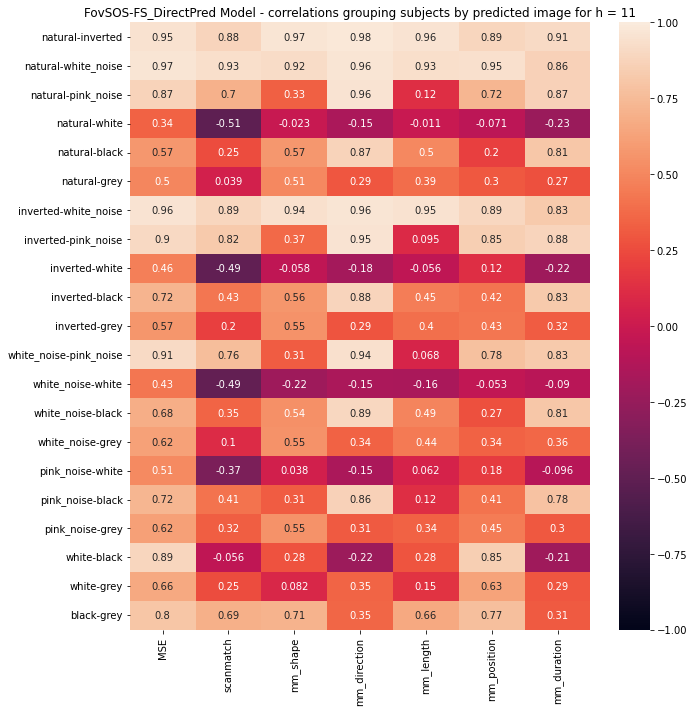

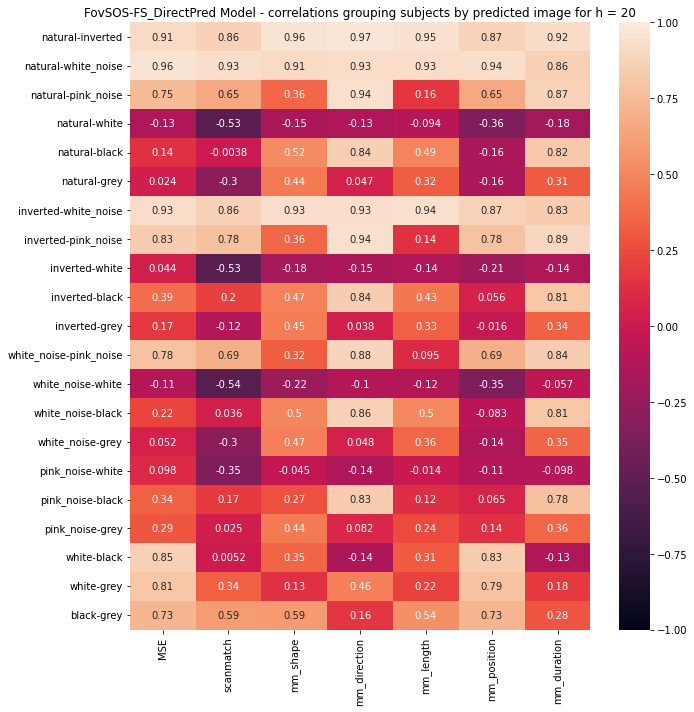

In [40]:
correlations_horizon = {}
for i, h in enumerate([1, 5, 11, 20]):
    correlations = {}
    #for metric in ["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "multimatch"]:
    #for metric in ["MSE", "peak_x", "peak_y", "scanmatch", "multimatch"]:
    for metric in ["MSE", "scanmatch", "multimatch"]:
        N, Nt = horizons[h][model_name]
        df = searcher.get_results_by_query(all_results, 
                         metric=metric, 
                         subject=None, 
                         tIMG=None, 
                         N=N,
                         Nt=Nt,
                         predIMG=None
                        )[0].apply(pd.Series)
        metrics_grouped_by_img_type = group_metrics(df, group_img_type="predIMG")
        if (metrics_grouped_by_img_type.std() == 0).any():
            df_loc = metrics_grouped_by_img_type.loc[:, (metrics_grouped_by_img_type.std() == 0)] 
            for i_col in df_loc.columns:
                metrics_grouped_by_img_type[i_col] += np.random.randn(len(df_loc)) * 1e-2
        metrics_used = metrics_grouped_by_img_type.index.get_level_values(0).unique()
        if len(metrics_used) > 1:
            for u, m_u in enumerate(metrics_used):
                corrs = metrics_grouped_by_img_type.loc[m_u].corr()
                if metric == "multimatch":
                    correlations[f"mm_{MULTIMATCH_DIMS[u]}"] = corrs
                else:
                    correlations[f"{metric}_{u}"] = corrs
        else:
            corrs = metrics_grouped_by_img_type.loc["metric_0"].corr()
            correlations[metric] = corrs
    correlations_horizon[h] = pd.concat(correlations)

    distributions = {}
    for i, p_img_type in enumerate(IMG_TYPES):
        for q_img_type in IMG_TYPES[i+1:]:
            dist = pd.concat(correlations_horizon).loc[h].loc[:, p_img_type][:, q_img_type]
            distributions[f"{p_img_type}-{q_img_type}"] = dist.to_frame().T

    df_distributions = pd.concat(distributions).droplevel(1)
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    sns.heatmap(df_distributions, ax=ax, annot=True, vmin=-1, vmax=1)
    ax.set_title(f"{model_name} Model - correlations grouping subjects by predicted image for h = {h}")
    fig.tight_layout()
    if is_save:
        savepath = os.path.join(SAVE_FOLDER, f"general/grouped/")
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        fig.savefig(f"{os.path.join(savepath, f'correlations_{h}_groupedPredicted')}.png")
    plt.show()

# Training one subject and Test with other using natural images 
## (retrieved from test_all_vs_all notebook)

In [41]:
def clean_all_vs_all(results_all_vs_all):
    for key in list(results_all_vs_all["all_vs_all"]):
        if (results_all_vs_all["all_vs_all"][key] == {}):
            results_all_vs_all["all_vs_all"].pop(key)
    return results_all_vs_all

In [42]:
results_all_vs_all = clean_all_vs_all(results_all_vs_all)

In [43]:
results_all_vs_all

{'all_vs_all': {'SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts_30-LR_0.0001-EPOCHS_5000-PAT_150': {'SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts_30-LR_0.0001-EPOCHS_5000-PAT_150': {},
   'SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts_30-LR_0.0001-EPOCHS_5000-PAT_150': {'natural': {'MSE': 833.5547376925,
     'peak_x': 5,
     'peak_y': 5,
     'multimatch': [0.9963636796,
      0.9662860624,
      0.9958577831,
      0.98718528,
      0.875],
     'scanmatch': 0.8912224656}},
   'SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts_30-LR_0.0001-EPOCHS_5000-PAT_150': {'natural': {'MSE': 3605.6159898805,
     'peak_x': 5,
     'peak_y': 5,
     'multimatch': [0.9958503455,
      0.9560034604,
      0.9950191679,
      0.9638598087,
      0.8216449208],
     'scanmatch': 0.7755386076}},
   'SUBJECT_s622-tIMG_natural-N_1-Nt_1-SEQ_10-InUts_30-LR_0.0001-EPOCHS_5000-PAT_150': {'natural': {'MSE': 3887.3486155877,
     'peak_x': 5,
     'peak_y': 5,
     'multimatch': [0.9949466731,
      0.9

In [44]:
searcher.get_results_by_query(results_all_vs_all, 
                             metric="multimatch", 
                             subject=None, 
                             tIMG="natural", 
                             N=None, 
                             Nt=None, 
                             SEQ=None, 
                             INuts=None, 
                             LR=None, 
                             EPOCHS=None, 
                             PAT=None, 
                             predIMG="natural", 
                             is_all_vs_all=True,
                             test_subject=None,
                           )[0].apply(pd.Series).describe()

0          1          2          3          4
count  48.000000  48.000000  48.000000  48.000000  48.000000
mean    0.994978   0.943581   0.992496   0.967814   0.716984
std     0.001901   0.031220   0.004053   0.011073   0.211573
min     0.987905   0.879516   0.977357   0.945214   0.333333
25%     0.994698   0.915359   0.991199   0.962205   0.500000
50%     0.995597   0.958470   0.994017   0.968054   0.798171
75%     0.996183   0.968266   0.994957   0.975590   0.903218
max     0.997524   0.974945   0.996495   0.990593   0.959127

In [45]:
searcher.get_results_by_query(all_results, 
                     metric="multimatch", 
                     subject=None, 
                     tIMG="natural", 
                     N=None, 
                     Nt=None, 
                     SEQ=None, 
                     INuts=None, 
                     LR=None, 
                     EPOCHS=None, 
                     PAT=None, 
                     predIMG="natural", 
                     #is_all_vs_all=True
                   )[0].apply(pd.Series)

0         1  \
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996695  0.957599   
SUBJECT_s605-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.996404  0.962654   
SUBJECT_s605-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.996524  0.956173   
SUBJECT_s605-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.996529  0.957168   
SUBJECT_s609-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.997749  0.894824   
SUBJECT_s609-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.997015  0.894244   
SUBJECT_s609-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.996547  0.870738   
SUBJECT_s609-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.997349  0.878515   
SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.997001  0.968200   
SUBJECT_s611-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.997033  0.963039   
SUBJECT_s611-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.996461  0.953673   
SUBJECT_s611-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.996871  0.964180   
SUBJECT_s613-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.997510  0.969040   
SUBJECT_s613-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.996776  0.961893   
SUBJECT_s613-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.996168  0.954419   
SUBJECT_s613-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.997420  0.972024   
SUBJECT_s616-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996519  0.970641   
SUBJECT_s616-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.996160  0.969102   
SUBJECT_s616-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.995471  0.962060   
SUBJECT_s616-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.996071  0.973541   
SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995875  0.963998   
SUBJECT_s617-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.995631  0.965041   
SUBJECT_s617-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.995050  0.955629   
SUBJECT_s617-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.995774  0.966791   
SUBJECT_s619-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996869  0.921512   
SUBJECT_s619-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.996253  0.892541   
SUBJECT_s619-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.996398  0.862484   
SUBJECT_s619-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.996876  0.905061   
SUBJECT_s620-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.997644  0.976931   
SUBJECT_s620-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.997251  0.974623   
SUBJECT_s620-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.996371  0.962020   
SUBJECT_s620-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.997237  0.974271   
SUBJECT_s622-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.997341  0.942256   
SUBJECT_s622-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.997085  0.943629   
SUBJECT_s622-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.996361  0.936176   
SUBJECT_s622-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.997204  0.945151   

                                                           2         3  \
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996351  0.992330   
SUBJECT_s605-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.995522  0.990988   
SUBJECT_s605-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.995338  0.989674   
SUBJECT_s605-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.995704  0.990704   
SUBJECT_s609-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996841  0.993027   
SUBJECT_s609-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.996664  0.990999   
SUBJECT_s609-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.995206  0.986982   
SUBJECT_s609-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.996841  0.991387   
SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995926  0.992764   
SUBJECT_s611-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.996027  0.991952   
SUBJECT_s611-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.994970  0.989419   
SUBJECT_s611-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.995867  0.992932   
SUBJECT_s613-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.997135  0.993455   
SUBJECT_s613-tIMG_natural-N_1-Nt_11-SEQ_10-InUt...  0.996216  0.992180   
SUBJECT_s613-tIMG_natural-N_1-Nt_20-SEQ_10-InUt...  0.994986  0.988653   
SUBJECT_s613-tIMG_natural-N_1-Nt_5-SEQ_10-InUts...  0.996888  0.993547   
SUBJECT_s616-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995156  

In [46]:
searcher.get_results_by_query(results_all_vs_all, 
                             metric=metric, 
                             subject=None, 
                             tIMG="natural", 
                             N=1, 
                             Nt=1, 
                             SEQ=None, 
                             INuts=None, 
                             LR=None, 
                             EPOCHS=None, 
                             PAT=None, 
                             predIMG="natural", 
                             is_all_vs_all=True,
                             test_subject=None,
                           )[0].apply(pd.Series)

0         1  \
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996270  0.900397   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995203  0.947999   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995909  0.960018   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.992955  0.958746   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.993233  0.961020   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995824  0.885258   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996744  0.972298   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995737  0.936093   
SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995665  0.957178   
SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996344  0.901917   
SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995423  0.965207   
SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.989995  0.971831   
SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995781  0.968365   
SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996436  0.932844   
SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995682  0.968233   
SUBJECT_s611-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995414  0.914990   
SUBJECT_s613-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996578  0.960509   
SUBJECT_s613-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996565  0.897806   
SUBJECT_s613-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995473  0.951958   
SUBJECT_s613-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.993259  0.966792   
SUBJECT_s613-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.993610  0.970796   
SUBJECT_s613-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995902  0.908159   
SUBJECT_s613-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.997524  0.973410   
SUBJECT_s613-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995636  0.931840   
SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995850  0.956003   
SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996600  0.879516   
SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996364  0.966286   
SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995258  0.958194   
SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.987905  0.974945   
SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996588  0.904697   
SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.994892  0.972823   
SUBJECT_s617-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.994947  0.915482   
SUBJECT_s620-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996352  0.957795   
SUBJECT_s620-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996481  0.892517   
SUBJECT_s620-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.994457  0.963113   
SUBJECT_s620-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.994778  0.969939   
SUBJECT_s620-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.993983  0.968527   
SUBJECT_s620-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.992908  0.972165   
SUBJECT_s620-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.994907  0.885510   
SUBJECT_s620-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996154  0.937392   
SUBJECT_s622-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995558  0.944195   
SUBJECT_s622-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995757  0.885706   
SUBJECT_s622-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.992966  0.965128   
SUBJECT_s622-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.992573  0.962207   
SUBJECT_s622-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995182  0.967505   
SUBJECT_s622-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.989911  0.970691   
SUBJECT_s622-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.996001  0.885784   
SUBJECT_s622-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995424  0.972090   

                                                           2         3  \
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.994937  0.949433   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.993380  0.969453   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.995539  0.973071   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.989477  0.976468   
SUBJECT_s605-tIMG_natural-N_1-Nt_1-SEQ_10-InUts...  0.989753  

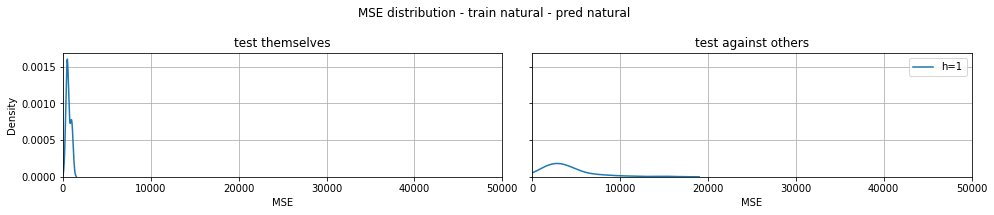

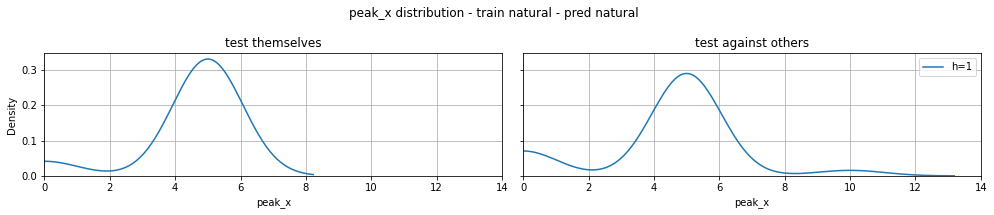

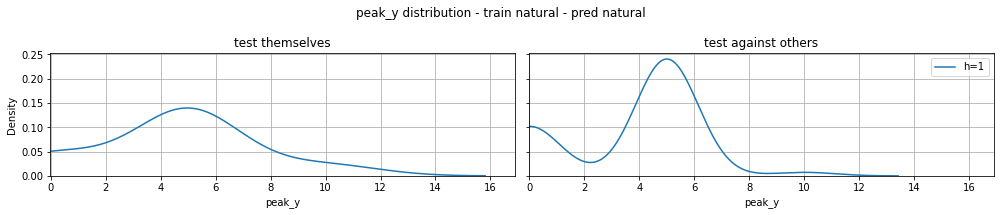

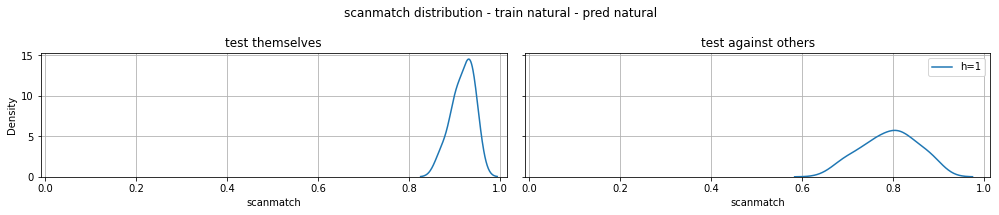

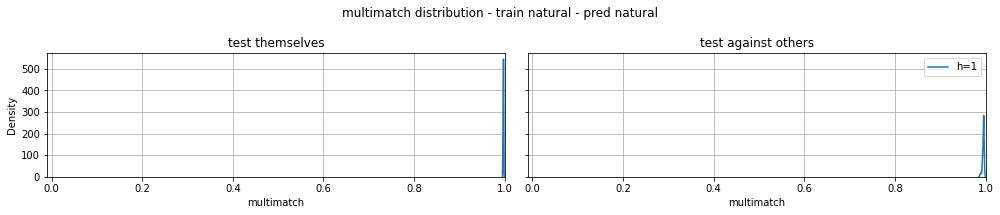

In [47]:
x_lim_right = {
    "MSE": 5e4
}
for metric in select_metrics:
    fig, ax = plt.subplots(1, 2, figsize=(14, 3), sharex=True, sharey=True)
    #for i, h in enumerate([1, 5, 11, 20]):
    for i, h in enumerate([1]):
        N, Nt = horizons[h][model_name]
        df_results_all_vs_all = searcher.get_results_by_query(results_all_vs_all, 
                             metric=metric, 
                             subject=None, 
                             tIMG="natural", 
                             N=N, 
                             Nt=Nt, 
                             SEQ=None, 
                             INuts=None, 
                             LR=None, 
                             EPOCHS=None, 
                             PAT=None, 
                             predIMG="natural", 
                             is_all_vs_all=True,
                             test_subject=None,
                           )[0].apply(pd.Series)
        df_results = searcher.get_results_by_query(all_results, 
                             metric=metric, 
                             subject=None, 
                             tIMG="natural", 
                             N=N, 
                             Nt=Nt, 
                             SEQ=None, 
                             INuts=None, 
                             LR=None, 
                             EPOCHS=None, 
                             PAT=None, 
                             predIMG="natural", 
                             is_all_vs_all=False
                           )[0].apply(pd.Series)  

        mu_all, sigma_all = df_results_all_vs_all[0].mean(), df_results_all_vs_all[0].std()
        x_all = np.linspace(mu_all - 3*sigma_all, mu_all + 3*sigma_all, 100)

        mu, sigma = df_results[0].mean(), df_results[0].std()
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

        #ax[0].plot(x_all, stats.norm.pdf(x_all, mu_all, sigma_all)*100, color=f"C{i}")
        #df_results_all_vs_all[0].plot.hist(bins=20, ax=ax[0], alpha=0.6, color=f"C{i}", label=f"h={N}")
        if not df_results_all_vs_all.empty:
            if (df_results_all_vs_all[0].std() != 0):
                sns.distplot(df_results_all_vs_all[0], ax=ax[1], label=f"h={h}", hist=False, kde=True, color=f"C{i}")
            else:
                ax[1].axvline(x=df_results_all_vs_all[0].mean(), label=f"h={h}", color=f"C{i}") 
        ax[1].set_xlabel(metric)

        #ax[1].plot(x, stats.norm.pdf(x, mu, sigma)*10, color=f"C{i}")
        #df_results[0].plot.hist(bins=20, ax=ax[1], alpha=0.6, color=f"C{i}", label=f"h={N}")
        if not df_results.empty:
            if (df_results[0].std() != 0):
                sns.distplot(df_results[0], ax=ax[0], label=f"h={h}", hist=False, kde=True, color=f"C{i}")
            else:
                ax[0].axvline(x=df_results[0].mean(), label=f"h={h}", color=f"C{i}")
        ax[0].set_xlabel(metric)

    ax[1].set_title(f"test against others")
    ax[0].set_title(f"test themselves")
    ax[1].set_xlim(left=-0.01, right=x_lim_right.get(metric, None))
    ax[0].set_xlim(left=-0.01, right=x_lim_right.get(metric, None))
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    fig.suptitle(f"{metric} distribution - train natural - pred natural")
    fig.tight_layout()
    if is_save:
        savepath = os.path.join(SAVE_FOLDER, f"general/grouped/{metric}/")
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        fig.savefig(f"{os.path.join(savepath, f'{metric}_testOthers')}.png")
    plt.show()

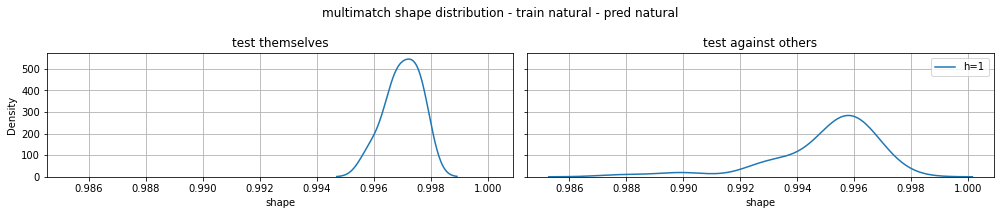

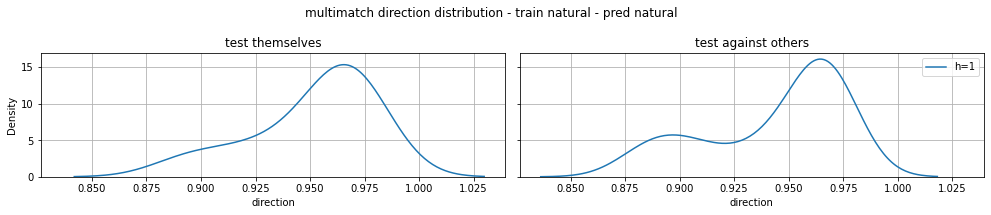

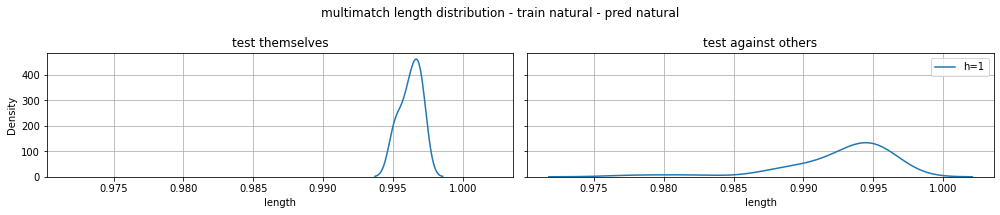

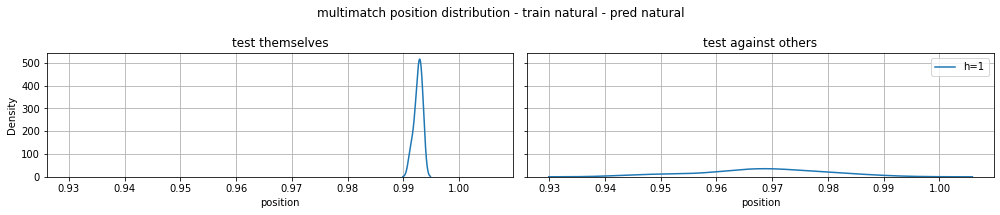

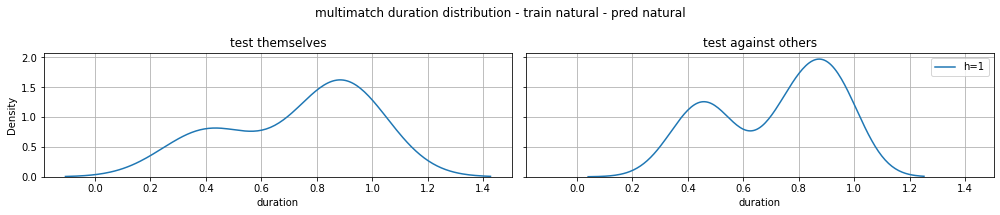

In [48]:
metric = "multimatch"
MULTIMATCH_DIMS = ["shape", "direction", "length", "position", "duration"]
for m_dim, multimatch_dim in enumerate(MULTIMATCH_DIMS):
    fig, ax = plt.subplots(1, 2, figsize=(14, 3), sharex=True, sharey=True)
    #for i, h in enumerate([1, 5, 11, 20]):
    for i, h in enumerate([1]):
        N, Nt = horizons[h][model_name]
        df_results_all_vs_all = searcher.get_results_by_query(results_all_vs_all, 
                             metric=metric, 
                             subject=None, 
                             tIMG="natural", 
                             N=N, 
                             Nt=Nt, 
                             SEQ=None, 
                             INuts=None, 
                             LR=None, 
                             EPOCHS=None, 
                             PAT=None, 
                             predIMG="natural", 
                             is_all_vs_all=True,
                             test_subject=None,
                           )[0].apply(pd.Series)
        df_results = searcher.get_results_by_query(all_results, 
                             metric=metric, 
                             subject=None, 
                             tIMG="natural", 
                             N=N, 
                             Nt=Nt, 
                             SEQ=None, 
                             INuts=None, 
                             LR=None, 
                             EPOCHS=None, 
                             PAT=None, 
                             predIMG="natural", 
                             is_all_vs_all=False
                           )[0].apply(pd.Series)  
    
        mu_all, sigma_all = df_results_all_vs_all[m_dim].mean(), df_results_all_vs_all[m_dim].std()
        x_all = np.linspace(mu_all - 3*sigma_all, mu_all + 3*sigma_all, 100)
        
        mu, sigma = df_results[m_dim].mean(), df_results[m_dim].std()
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        
        #ax[0].plot(x_all, stats.norm.pdf(x_all, mu_all, sigma_all), color=f"C{i}")
        #df_results_all_vs_all[m_dim].plot.hist(bins=20, ax=ax[0], alpha=0.6, color=f"C{i}", label=f"h={N}")
        sns.distplot(df_results_all_vs_all[m_dim], ax=ax[1], label=f"h={h}", hist=False, kde=True)
        ax[1].set_xlabel(multimatch_dim)
        
        #ax[1].plot(x, stats.norm.pdf(x, mu, sigma), color=f"C{i}")
        #df_results[m_dim].plot.hist(bins=20, ax=ax[1], alpha=0.6, color=f"C{i}", label=f"h={N}")
        sns.distplot(df_results[m_dim], ax=ax[0], label=f"h={h}", hist=False, kde=True)
        ax[0].set_xlabel(multimatch_dim)
        
    ax[1].set_title(f"test against others")
    ax[0].set_title(f"test themselves")
    plt.suptitle(f"multimatch {multimatch_dim} distribution - train natural - pred natural")
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    fig.tight_layout()
    if is_save:
        savepath = os.path.join(SAVE_FOLDER, f"general/grouped/{metric}/")
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        fig.savefig(f"{os.path.join(savepath, f'{multimatch_dim}_testOthers')}.png")
    plt.show()

## Plot for train subject and test subject

===========> Loading npz data from natural images
===========> Loading npz data from natural images
===========> Loading npz data from natural images
===========> Loading npz data from natural images


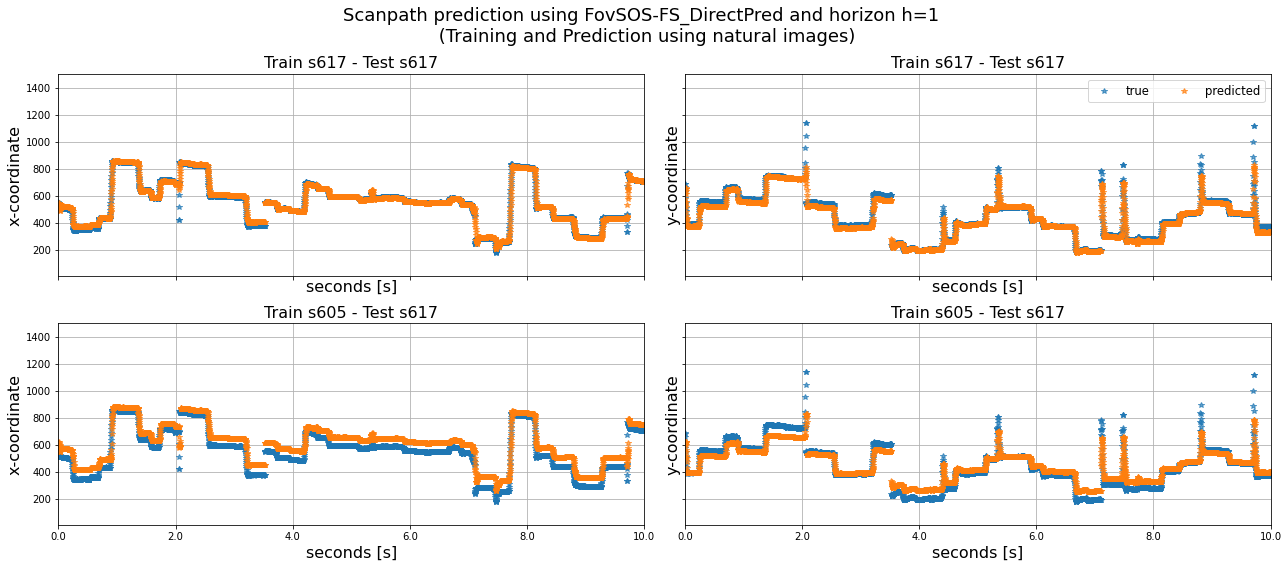

In [49]:
# Params
N = 1
#Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 5000, 150
get_mcdropout_results = False
tIMG = "natural"
predIMG = "natural"
# Subjects
subject_train1 = "s617" #s605, s617, s620
#subject_train2 = "s609"
subject_train2 = "s605"
subject_test = subject_train1

x_lim = (0, 5000)

# Plot
fig, ax = plt.subplots(2, 2, figsize=(18,8), sharex=True, sharey=True)
for i, x_or_y in enumerate(["x", "y"]):
    # Test against themselves
    # -----------------------
    # Folders
    train_path = f"SUBJECT_{subject_train1}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

    folder_path_themselves = os.path.join(RESULTS_FOLDER,
                              train_path)
    # Load results
    if get_mcdropout_results:
        y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                          predIMG, 
                                                          get_mcdropout_results=True)
    else:
        y_real, y_pred = load_npz(folder_path_themselves, 
                                  predIMG, 
                                  get_mcdropout_results=False)
    y_real.reset_index(inplace=True, drop=True)
    y_pred.reset_index(inplace=True, drop=True)
    if get_mcdropout_results:
        mcdropout_mean.reset_index(inplace=True, drop=True)
        mcdropout_std.reset_index(inplace=True, drop=True)

    #plot
    ax[0, i].plot(y_real[x_or_y], 'C0*', label='true', alpha=0.7)
    ax[0, i].plot(y_pred[x_or_y], 'C1*', label='predicted', alpha=0.7)
    #ax[0, i].plot(mcdropout_mean[x_or_y], 'C2-', label='MC-Dropout expectation', alpha=0.6)
    #ax[0, i].fill_between(y_real[x_or_y].index, mcdropout_mean[x_or_y] - 2*mcdropout_std[x_or_y],
    #                 mcdropout_mean[x_or_y] + 2*mcdropout_std[x_or_y], 
    #                   color='C2', alpha=0.2, label='MC-Dropout uncertainty')
    
    #ax[0].legend(loc='best', prop={'size': 13})
    ax[0, i].grid()
    ax[0, i].set_ylabel(f"{x_or_y}-coordinate", fontsize=16)
    ax[0, i].set_xlabel("seconds [s]", fontsize=16)
    if x_lim:
        ax[0, i].set_xlim(x_lim[0], x_lim[1])
    #print(ax[0].get_xticks())
    ax[0, i].set_xticklabels(ax[0, i].get_xticks()*2/1000)
    ax[0, i].set_title(f"Train {subject_train1} - Test {subject_test}", fontsize=16)
        
    #plot_mcdropout(y_real, y_pred, mcdropout_mean, mcdropout_std, x_or_y)
    #plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=(3600, 3750))#(5450,5500))#(3600, 3750))
    #plot_config_prediction(x_or_y, subject_train1, subject_train1, N=N, x_lim=x_lim)
    #plt.show()

    # Test against other
    # -------------------
    # Folders
    train_path = f"SUBJECT_{subject_train2}-tIMG_{tIMG}-N_{1}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"
    test_path = f"SUBJECT_{subject_test}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

    folder_path_others = os.path.join(RESULTS_FOLDER,
                              train_path,
                               "all_vs_all",
                              test_path)
    # Load results
    if get_mcdropout_results:
        y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_others, 
                                                          predIMG, 
                                                          get_mcdropout_results=True)
    else:
        y_real, y_pred = load_npz(folder_path_others, 
                                  predIMG, 
                                  get_mcdropout_results=False)

    y_real.reset_index(inplace=True, drop=True)
    y_pred.reset_index(inplace=True, drop=True)
    if get_mcdropout_results:
        mcdropout_mean.reset_index(inplace=True, drop=True)
        mcdropout_std.reset_index(inplace=True, drop=True)

    # Plot
    ax[1, i].plot(y_real[x_or_y], 'C0*', label='true', alpha=0.7)
    ax[1, i].plot(y_pred[x_or_y], 'C1*', label='predicted', alpha=0.7)
    #ax[1, i].plot(mcdropout_mean[x_or_y], 'C2-', label='MC-Dropout expectation', alpha=0.6)
    #ax[1, i].fill_between(y_real[x_or_y].index, mcdropout_mean[x_or_y] - 2*mcdropout_std[x_or_y],
    #                 mcdropout_mean[x_or_y] + 2*mcdropout_std[x_or_y], color='C2', alpha=0.2, label='MC-Dropout uncertainty')
    
    ax[1, i].grid()
    ax[1, i].set_ylabel(f"{x_or_y}-coordinate", fontsize=16)
    ax[1, i].set_xlabel("seconds [s]", fontsize=16)
    if x_lim:
        ax[1, i].set_xlim(x_lim[0], x_lim[1])
    ax[1, i].set_ylim(None, 1500)
    ax[0, i].set_xticklabels(ax[0, i].get_xticks()*2/1000)
    ax[1, i].set_title(f"Train {subject_train2} - Test {subject_test}", fontsize=16)
    
    fig.suptitle(f'Scanpath prediction using {model_name} and horizon h={N} \n (Training and Prediction using natural images)', fontsize=18)
    fig.tight_layout()
ax[0, 1].legend(loc='best', ncol=4, prop={'size': 11.6})

if is_save:
    savepath = os.path.join(SAVE_FOLDER, f"general/grouped/")
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    fig.savefig(f"{os.path.join(savepath, f'scanpath_testOthers_{N}_{subject_test}')}.png")

### Others test

In [50]:
# Params
#N = 5
N = 1
#Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 5000, 150

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s605" #s605, s617, s620

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(RESULTS_FOLDER,
                          train_path)

if get_mcdropout_results:
    # Load results
    y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                          predIMG, 
                                                          get_mcdropout_results=True)
else:
    y_real, y_pred = load_npz(folder_path_themselves, 
                              predIMG, 
                              get_mcdropout_results=False)

===========> Loading npz data from natural images


In [51]:
# check if can generate groups of images from indexed load_npz
init_img_idx = np.where(y_pred.index[0] == y_pred.index)[0]
groups_generated = [y_pred.iloc[init_img_idx[i]:init_img_idx[i+1]] for i in range(len(init_img_idx)-1)]

In [52]:
from main_classes.MetricsCalculator import eyeBehaviour, format_output_eyeBehaviour, eyeBehaviour_remodnav, format_output_remodnav

In [53]:
def detect_from_scanpath(y, fn="eyeBehaviour"):
    if fn == "eyeBehaviour":
        idx = np.expand_dims(np.arange(len(y)), -1)
        y = np.concatenate([idx, y], axis=1)
    eyeBehaviour_fn = eyeBehaviour if fn == "eyeBehaviour" else eyeBehaviour_remodnav
    format_fn = format_output_eyeBehaviour if fn == "eyeBehaviour" else format_output_remodnav
    events = eyeBehaviour_fn(y)
    sac, fix = format_fn(events)
    return sac, fix

In [54]:
def calculate_multimatch(y_real, y_pred, screensize=[1920, 1080],
                         grouping=False,
                         TDir=0.0,
                         TDur=0.0,
                         TAmp=0.0,
                         fn="eyeBehaviour"):
    """
    Calculate multimatch metrics.
    """
    import multimatch_gaze as m
    _, fix_real = detect_from_scanpath(y_real, fn=fn)
    _, fix_pred = detect_from_scanpath(y_pred, fn=fn)
    #return m.docomparison(fix_real, fix_pred, screensize=[1280, 720])
    return m.docomparison(fix_real, fix_pred, screensize=screensize)#, grouping=grouping, TDir=TDir, TDur=TDur, TAmp=TAmp)

In [55]:
# Params
#N = 11
N = 1
#Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 5000, 150

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s617" #"s620" #s605, s617, s620
subject_test = "s620" #"s622"

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(RESULTS_FOLDER,
                          train_path)

if get_mcdropout_results:
# Load results
    y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
else:
    y_real, y_pred = load_npz(folder_path_themselves, 
                              predIMG, 
                              get_mcdropout_results=False)
    
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
if get_mcdropout_results:
    mcdropout_mean.reset_index(inplace=True, drop=True)
    mcdropout_std.reset_index(inplace=True, drop=True)

print("MULTI")
print(
    calculate_multimatch(y_real, y_pred)
)

print(json.dumps(all_results[predIMG][train_path], indent=2))

# Plot
for x_or_y in ["x", "y"]:
    plot_mcdropout(y_real, y_pred, mcdropout_mean, mcdropout_std, x_or_y)
    #plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=(3600, 3750))#(5450,5500))#(3600, 3750))
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=(5000,7000))
    plt.show()
    
# Test against other
# -------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{1}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"
test_path = f"SUBJECT_{subject_test}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_others = os.path.join(RESULTS_FOLDER,
                          train_path,
                           "all_vs_all",
                          test_path)
if get_mcdropout_results:
    # Load results
    y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_others, 
                                                          predIMG, 
                                                          get_mcdropout_results=True)
else:
    y_real, y_pred = load_npz(folder_path_others, 
                      predIMG, 
                      get_mcdropout_results=False)

y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
if get_mcdropout_results:
    mcdropout_mean.reset_index(inplace=True, drop=True)
    mcdropout_std.reset_index(inplace=True, drop=True)

print("MULTI")
print(
    calculate_multimatch(y_real, y_pred,
                        )
)
print(
    calculate_multimatch(y_real, y_pred,
                         grouping=True,
                        TDir=0.0,
                         TDur=0.0,
                         TAmp=0.0)
)

print(json.dumps(results_all_vs_all["all_vs_all"][train_path][test_path][predIMG], indent=2))

# Plot
for x_or_y in ["x", "y"]:
    if get_mcdropout_results:
        plot_mcdropout(y_real, y_pred, mcdropout_mean, mcdropout_std, x_or_y)
    else:
        plot_p
    #plot_config_prediction(x_or_y, subject_train, subject_test, N=N, x_lim=(4765,4890))
    plot_config_prediction(x_or_y, subject_train, subject_test, N=N, x_lim=(13000,15000))
    plt.show()

===========> Loading npz data from natural images
MULTI
[0.9958752197809029, 0.963997999262679, 0.9951698659978768, 0.9920040755517884, 0.8831168831168832]
{
  "MSE": 1012.9288837894,
  "peak_x": 5,
  "peak_y": 10,
  "multimatch": [
    0.9958752198,
    0.9639979993,
    0.995169866,
    0.9920040756,
    0.8831168831
  ],
  "dtw": 383668.3895591222,
  "scanmatch": 0.9012345679,
  "rec": 18.3074534161
}


NameError: name 'mcdropout_mean' is not defined

In [ ]:
# Params
N = 5
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s622"

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

print(json.dumps(all_results[predIMG][train_path], indent=2))

# Plot
for x_or_y in ["x", "y"]:
    plot_mcdropout(y_real, y_pred, mcdropout_mean, mcdropout_std, x_or_y)
    #plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=(3600, 3750))#(5450,5500))#(3600, 3750))
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=(0,10000))
    plt.show()

In [ ]:
# Params
N = 5
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s620"

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

print(json.dumps(all_results[predIMG][train_path], indent=2))

# Plot
for x_or_y in ["x", "y"]:
    plot_mcdropout(y_real, y_pred, mcdropout_mean, mcdropout_std, x_or_y)
    #plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=(3600, 3750))#(5450,5500))#(3600, 3750))
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=(0,10000))
    plt.show()
    
# ==============================

# Params
N = 5
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s619" #"s620" #s605, s617, s620

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

print(json.dumps(all_results[predIMG][train_path], indent=2))

# Plot
for x_or_y in ["x", "y"]:
    plot_mcdropout(y_real, y_pred, mcdropout_mean, mcdropout_std, x_or_y)
    #plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=(3600, 3750))#(5450,5500))#(3600, 3750))
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=(0,10000))
    plt.show()

# Specifics Results

In [ ]:
# Specifics
subject = None #"s629" #"s605"
N = None 
Nt, SEQ, INuts, LR, EPOCHS, PAT = None, None, None, None, None, None

pivot = "N"
is_all_vs_all = False

is_raw = True
is_grouped = True

#is_save = True

groups = {}
for tIMG in ['natural', 'inverted',  'pink_noise', 'white_noise', 'white', 'black', 'grey']:
    for predIMG in ['natural', 'inverted',  'pink_noise', 'white_noise', 'white', 'black', 'grey']: #['natural', 'white', 'black', 'grey', 'inverted', 'pink_noise', 'white_noise']:
        print(f"==================== tIMG={tIMG} | predIMG={predIMG} =======================")
        for metric in ["MSE", "peak_x", "peak_y", "multimatch", "dtw", "scanmatch", "rec", "det"]:
            df_results = searcher.get_results_by_query(all_results, 
                                                       metric, 
                                                       subject, 
                                                       tIMG, 
                                                       N, 
                                                       Nt, 
                                                       SEQ, 
                                                       INuts, 
                                                       LR, 
                                                       EPOCHS, 
                                                       PAT, 
                                                       predIMG, 
                                                       is_all_vs_all=False)            
            if is_raw:
                plot_metric_results(df_results, metric, pivot, tIMG=tIMG, predIMG=predIMG, is_save=is_save, save_folder=SAVE_FOLDER)
            if is_grouped:
                grouped_results = searcher.get_statistical_groups(df_results, steps_ahead=[1, 5, 11, 20])
                groups.setdefault(metric, {})[f"{tIMG}-{predIMG}"] = grouped_results 
                plot_statistical_groups(grouped_results, metric, tIMG=tIMG, predIMG=predIMG, is_save=is_save, save_folder=SAVE_FOLDER)

# Correlation Analysis

In [ ]:
def get_img_type_groups(df, is_tIMG=True, img_types=['natural', 'inverted',  'pink_noise', 'white_noise', 'white', 'black', 'grey']):
    img_type_groups = []
    for img_type in img_types:
        if is_tIMG:
            img_type_groups.append(df[df.index.str.startswith(f"{img_type}-")])
        else:
            img_type_groups.append(df[df.index.str.endswith(f"-{img_type}")])
    return img_type_groups

def group_by_tIMG_or_predIMG(df, is_tIMG=True):
    img_type_groups = get_img_type_groups(df, is_tIMG=is_tIMG)
    list_groups = []
    for df_group in img_type_groups:
        df_copy = pd.DataFrame(df_group)
        if is_tIMG:
            df_copy["index"] = df_group.index[0].split("-")[0]
        else:
            df_copy["index"] = df_group.index[0].split("-")[1]
        list_groups.append(df_copy)
    df_groups = pd.concat(list_groups)
    df_groups.set_index("index", inplace=True)
    return df_groups

In [ ]:
def plot_PCA(df, is_tIMG, metric=None, step_ahead=None, is_save=False):
    # PCA-analysis
    from sklearn.decomposition import PCA, FastICA, KernelPCA
    pca = PCA(n_components=2)
    #pca = KernelPCA(n_components=2, kernel="rbf", gamma=gamma)
    pca_arr = pca.fit_transform(df)
    # PCA 2 comps to DataFrame
    df_pca = pd.DataFrame(pca_arr, index=df.index)
    img_type_groups = get_img_type_groups(df_pca, is_tIMG=is_tIMG)

    fig, ax = plt.subplots(1, figsize=(7,5))
    for i, img_type_group in enumerate(img_type_groups):
        img_type_group.plot.scatter(x=0, y=1, c=f"C{i}", ax=ax, label=img_type_group.index[0].split('-')[int(~is_tIMG)])
    ax.legend(loc="best", prop={'size': 9})
    ax.set_xlabel("Component 0")
    ax.set_ylabel("Component 1")
    ax.set_title(f"PCA-{metric} for {step} steps ahead grouped by train image")
    if is_save:
        savepath = os.path.join(SAVE_FOLDER, f"general/grouped/{metric}/")
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        fig.savefig(f"{os.path.join(savepath, f'PCA_{metric}-step_{step_ahead}-istIMG_{is_tIMG}')}.png")
    plt.show()
    
def plot_parallel_coordinates(df, is_tIMG, metric=None, step_ahead=None, is_save=False):
    df_groups = group_by_tIMG_or_predIMG(df, is_tIMG=is_tIMG)
    from pandas.plotting import parallel_coordinates
    fig, ax = plt.subplots(figsize=(10,5))
    color = (f"C{i}" for i in range(len(df_groups.index.unique())))
    parallel_coordinates(df_groups.reset_index(), "index", ax=ax, color=color)
    ax.legend(loc="best")
    ax.set_title(f"Parallel coordinates-{metric} for {step_ahead} steps ahead grouped by train image")
    if is_save:
        savepath = os.path.join(SAVE_FOLDER, f"general/grouped/{metric}/")
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        fig.savefig(f"{os.path.join(savepath, f'parallel_{metric}-step_{step_ahead}-istIMG_{is_tIMG}')}.png")
    plt.show()
    
def calculate_correlations(df, is_tIMG):
    df_groups = group_by_tIMG_or_predIMG(df, is_tIMG=is_tIMG)
    dict_of_dfs = {}
    for img_type in df_groups.index.unique():
        for i_comp in df_groups.columns:
            df_comp = df_groups.loc[img_type][i_comp].to_frame().reset_index(drop=True).T
            df_comp.index = [img_type]
            dict_of_dfs.setdefault(i_comp, []).append(df_comp)
    corr_comps = []
    for i_comp in dict_of_dfs.keys():
        corr_comps.append(pd.concat(dict_of_dfs[i_comp]).T.corr())
    return corr_comps

def plot_correlations(df, is_tIMG, metric=None, step_ahead=None, is_save=False):
    import seaborn as sns
    corr_comps = calculate_correlations(df, is_tIMG)
    for i, corr_comp in enumerate(corr_comps):
        fig, ax = plt.subplots()
        sns.heatmap(corr_comp, 
            xticklabels=corr_comp.columns,
            yticklabels=corr_comp.columns, ax=ax, annot=True, 
                    vmin=-1, vmax=1)
        if metric == "multimatch":
            i = ["shape", "direction", "length", "position", "duration"][i]
        if isinstance(metric, list):
            i = metric[i]
        ax.set_title(f"Correlation matrix for {step_ahead} steps ahead grouped by train image \n {metric} component {i}")
        if is_save:
            savepath = os.path.join(SAVE_FOLDER, f"general/grouped/{metric}/")
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            fig.savefig(f"{os.path.join(savepath, f'corr_{metric}-step_{step_ahead}-comp_{i}-istIMG_{is_tIMG}')}.png")
    plt.show()

In [ ]:
df_results[0].apply(pd.Series)

In [ ]:
pd.DataFrame(groups["multimatch"]).loc[5].apply(pd.Series)["mean"].apply(pd.Series)

In [ ]:
metric = "multimatch"
is_tIMG = True
#is_save = True

for step in [1, 5, 11, 20]:
    df = pd.DataFrame(groups[metric]).loc[step].apply(pd.Series)["mean"].apply(pd.Series)
    plot_PCA(df, is_tIMG, metric=metric, step_ahead=step, is_save=is_save)
#for step in [1, 5, 11, 20]:
#    df = pd.DataFrame(groups[metric]).loc[step].apply(pd.Series)["mean"].apply(pd.Series)
#    plot_parallel_coordinates(df, is_tIMG, metric=metric, step_ahead=step, is_save=is_save)
for step in [1, 5, 11, 20]:
    df = pd.DataFrame(groups[metric]).loc[step].apply(pd.Series)["mean"].apply(pd.Series)
    plot_correlations(df, is_tIMG, metric=metric, step_ahead=step, is_save=is_save)

In [ ]:
#metrics = ["MSE", "peak_x", "peak_y", "dtw", "scanmatch", "rec", "det"]
metrics = ["MSE", "peak_x", "peak_y", "scanmatch"]
#metrics = ["MSE", "dtw", "scanmatch"]
is_tIMG = True
#is_save = True

for step in [1, 5, 11, 20]:
    dfs = []
    for metric in metrics:
        df = pd.DataFrame(groups[metric]).loc[step].apply(pd.Series)["mean"].apply(pd.Series)
        dfs.append(df)
    df_concat = pd.concat(dfs, axis=1)
    df_concat.columns = metrics
    plot_correlations(df_concat, is_tIMG, metric=metrics, step_ahead=step, is_save=is_save)